# Credit Card Approval Predictor

### Life cycle of Our Project
- Understanding the Problem Statement
- Data Collection
- Data Checks to perform
- Exploratory data analysis
- Data Pre-Processing
- Model Training
- Choose best model

### 1. Problem Statement

This project aims to identify the factors affecting credit card prediction of applicants. Credit Card Company dims the customer to be risky if they have missed payment history. We would combine the credit card payment history with the demographic details of the customer. 

### 2. Data Collection

- Dataset Source: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction
- The data consists 2 csv files.
    - The application data contains 18 columns and 45985 rows.
    - The payment history data contains 3 columns and 1048575 rows.

### 2.1 Importing data and required packages

### Importing Pandas, Numpy, Seaborn and Warning Packages.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import warnings
import math
warnings.filterwarnings('ignore')

%matplotlib inline

from scipy.stats import iqr
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

from imblearn.over_sampling import SMOTE

### Import the CSV Data to Pandas DataFrame

In [2]:
credit_record = pd.read_csv("data//credit_record.csv")
application_record = pd.read_csv("data//application_record.csv")

### Let's have a look at our data!

In [3]:
credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


### Shape of the credit data

In [4]:
credit_record.shape

(1048575, 3)

### The credit records contains data for customers with multiple months. Lets figure out how many unique cuustomer records we have.  

In [5]:
len(credit_record.ID.unique())

45985

We have customer payment history data of 45985 unique customers.

### Let's have look at customer application data.

In [6]:
application_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


### Shape of the data

In [7]:
application_record.shape

(438557, 18)

In [8]:
len(application_record.ID.unique())

438510

### 2.2 Dataset information

Application data
- ID : Client number
- CODE_GENDER: Gender
- FLAG_OWN_CAR : Is there a car
- FLAG_OWN_REALTY : Is there a property
- CNT_CHILDREN : Number of children
- AMT_INCOME_TOTAL : Annual income
- NAME_INCOME_TYPE : Income category
- NAME_EDUCATION_TYPE : Education level
- NAME_FAMILY_STATUS : Marital status
- NAME_HOUSING_TYPE : Way of living
- DAYS_BIRTH : Birthday; Count backwards from current day (0), -1 means yesterday
- DAYS_EMPLOYED : Start date of employment; Count backwards from current day(0). If positive, it means the person currently unemployed.
- FLAG_MOBIL : Is there a mobile phone
- FLAG_WORK_PHONE : Is there a work phone
- FLAG_PHONE : Is there a phone
- FLAG_EMAIL : Is there an email
- OCCUPATION_TYPE : Occupation
- CNT_FAM_MEMBERS : Family size
    
Credit record data
- ID : Client number
- MONTHS_BALANCE : Record month; The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
- STATUS : Status0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

### 3. Creating a target variable

From the unique applicant IDs in both the datasets, it is evident that not all the applicants have credit history. A major reason behind this can be that they were not approved for the credit card. We would assume our analysis on the ground that Credit Card Company did not find these customers fit to issue a credit.

We would create a "is_risky_customer" target variablee, to identify a risky client for Credit card company, they would have less chances of getting approved for a credit card.  

We would consider following two criterias for a risky customers:
- Customer who were already rejected for a credit card
- We would consider applicants over 60 days overdue are bad clients. This target variable "is_risky_customer" is 1 for a bad client and 0 for a good applicant. 

### 3.1 Create Target Variable and assign value for rejected customers

We would store the customer ids of with existing credit history, i.e. approved customer.

In [9]:
existing_clients = credit_record.ID.unique()

We would create our target variable, "is_risky_customer" and assign a value "0" to existing clients and "1" to rejected applicants.

In [10]:
application_record["is_risky_customer"] = application_record["ID"].apply(lambda i: 0 if i in existing_clients else 1)
application_record

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,is_risky_customer
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0,1
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0,1
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0,1
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0,1


In [11]:
application_record["is_risky_customer"].value_counts()

1    402100
0     36457
Name: is_risky_customer, dtype: int64

### 3.2 Bad Credit History Customers

To further classify our applicants, we would check the credit history of existing clients. The applicant must have looked good at the time approval of his/her credit card, but their payment history may say otherwise. We would like mark thses customers as risky customers. The main purpose behind this, to see if there are any same demographic conditions and avoid them in the future.  

###  Selecting the bad clients from credit_record

In [12]:
credit_record_filtered = credit_record[(credit_record['STATUS'] == "2") | (credit_record['STATUS'] == "3") | (credit_record['STATUS'] == "4") | (credit_record['STATUS'] == "5")]

In [13]:
credit_record_filtered

,ID,MONTHS_BALANCE,STATUS
8911,5002126,-46,2
8912,5002126,-47,3
8913,5002126,-48,3
8914,5002126,-49,2
8915,5002126,-50,2
...,...,...,...
1041047,5149838,-23,2
1041048,5149838,-24,2
1044484,5150049,0,2
1046235,5150238,-5,2


In [14]:
updated = application_record["ID"].isin(credit_record_filtered["ID"])
updated

0         False
1         False
2         False
3         False
4         False
          ...  
438552    False
438553    False
438554    False
438555    False
438556    False
Name: ID, Length: 438557, dtype: bool

In [15]:
application_record.loc[updated, "is_risky_customer"] = 1

In [16]:
application_record["is_risky_customer"].value_counts()

1    402716
0     35841
Name: is_risky_customer, dtype: int64

### 4. Data Quality Checks

- Check data type
- Renaming features
- Check Missing values
- Check Duplicates
- Check the number of unique values of each column
- Check statistics of data set
- Check various categories present in the different categorical column

### 4.1 Let's check data types for all the values

In [17]:
application_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

### 4.2 Renaming the features

In [18]:
application_record = application_record.rename(columns={
    'CODE_GENDER' : 'gender',
    'FLAG_OWN_CAR' : 'has_a_car',
    'FLAG_OWN_REALTY' : 'has_a_property',
    'CNT_CHILDREN' : 'no_of_children',
    'AMT_INCOME_TOTAL' : 'income',
    'NAME_INCOME_TYPE' : 'employment_status',
    'NAME_EDUCATION_TYPE' : 'education_level',
    'NAME_FAMILY_STATUS' : 'marital_status',
    'NAME_HOUSING_TYPE' : 'housing',
    'DAYS_BIRTH' : 'age',
    'DAYS_EMPLOYED' : 'employment_length',
    'FLAG_MOBIL': 'has_a_mobile',
    'FLAG_WORK_PHONE' : 'has_a_workphone',
    'FLAG_PHONE': 'has_a_phone',
    'FLAG_EMAIL': 'has_an_email',
    'OCCUPATION_TYPE': 'job_title',
    'CNT_FAM_MEMBERS': 'family_member_count'
})

In [19]:
application_record.head()

,ID,gender,has_a_car,has_a_property,no_of_children,income,employment_status,education_level,marital_status,housing,age,employment_length,has_a_mobile,has_a_workphone,has_a_phone,has_an_email,job_title,family_member_count,is_risky_customer
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


In [20]:
application_record.to_csv("data//application_record_combined.csv", sep=',', encoding='utf-8')

### 4.3 Check Missing Values

In [21]:
application_record.isna().sum()

ID                          0
gender                      0
has_a_car                   0
has_a_property              0
no_of_children              0
income                      0
employment_status           0
education_level             0
marital_status              0
housing                     0
age                         0
employment_length           0
has_a_mobile                0
has_a_workphone             0
has_a_phone                 0
has_an_email                0
job_title              134203
family_member_count         0
is_risky_customer           0
dtype: int64

#### Insight

- job_title has 134203 missing values.

### changing null job-title to "unknown"

In [22]:
application_record['job_title'].fillna("Unknown", inplace = True)

### 4.4 Check for duplicates

In [23]:
application_record.duplicated().sum()

0

There are no duplicates in the data.

### 4.5 Check the number of unique values of each column

In [24]:
application_record.nunique()

ID                     438510
gender                      2
has_a_car                   2
has_a_property              2
no_of_children             12
income                    866
employment_status           5
education_level             5
marital_status              5
housing                     6
age                     16379
employment_length        9406
has_a_mobile                1
has_a_workphone             2
has_a_phone                 2
has_an_email                2
job_title                  19
family_member_count        13
is_risky_customer           2
dtype: int64

### 4.6 Get variable categories for our data!

In [25]:
num_cols = application_record._get_numeric_data().columns
num_cols

Index(['ID', 'no_of_children', 'income', 'age', 'employment_length',
       'has_a_mobile', 'has_a_workphone', 'has_a_phone', 'has_an_email',
       'family_member_count', 'is_risky_customer'],
      dtype='object')

In [26]:
cols = application_record.columns

In [27]:
categorical_cols = list(set(cols) - set(num_cols))
categorical_cols

['employment_status',
 'job_title',
 'housing',
 'gender',
 'has_a_car',
 'marital_status',
 'has_a_property',
 'education_level']

### 4.7 Check statistics of data set

In [28]:
application_record.describe()

,ID,no_of_children,income,age,employment_length,has_a_mobile,has_a_workphone,has_a_phone,has_an_email,family_member_count,is_risky_customer
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465,0.918275
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207,0.273945
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000,1.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000,1.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000,1.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,1.000000


### Insights

- We have many boolean datatype features, has_a_mobile, has_a_workphone, has_a_phone, has_an_email.
- Most of the applicants do not have children, even 75th percentile is 1. But there is an unusual high value of 19.
- Employement length is in days and need to be converted in years.
- The employment length has both positive and negative values. 
- Same as number of children, minimum members in family is 1 with mean family members being 2 and some unusual cases of 20.

### 4.8 Exploring Data

### 4.8.1 Univariate Analysis

In [29]:
def frequency(df, feature):
    '''Function that will return the count and frequency of each class withing the feature
       input : 
           df : dataset 
           feature: feature        
    '''
    
    # get the count of each of each class
    feature_count = df[feature].value_counts()
    
    # frequency of each feature
    feature_frequency = df[feature].value_counts(normalize = True) * 100
    
    # concat the results
    feature_stat = pd.concat([feature_count,feature_frequency], axis = 1)
    
    # renaming the columns
    feature_stat.columns = ['Count','Frequency (%)']
    
    return feature_stat

In [30]:
def univariate_categorical(df, feature):
    print('Description:\n{}'.format(df[feature].describe()))
    print('*'*50)
    value_cnt = frequency(df,feature)
    print('Value count:\n{}'.format(value_cnt))


In [31]:
# function to create a bar chart plot
def create_bar_plot(df,feature,angle):
    fig, ax = plt.subplots(figsize = (6,10))
    sns.barplot(x=frequency(df,feature).index,y=frequency(df,feature).values[:,0])
    plt.xlabel('{}'.format(feature))
    plt.ylabel('Count')
    plt.title('{} count'.format(feature))
    plt.xticks(rotation=angle)
    return plt.show()

### 4.8.1.1 Gender

In [32]:
frequency(application_record, 'gender')

,Count,Frequency (%)
F,294440,67.138365
M,144117,32.861635


Does gender affect the credit defaultness?

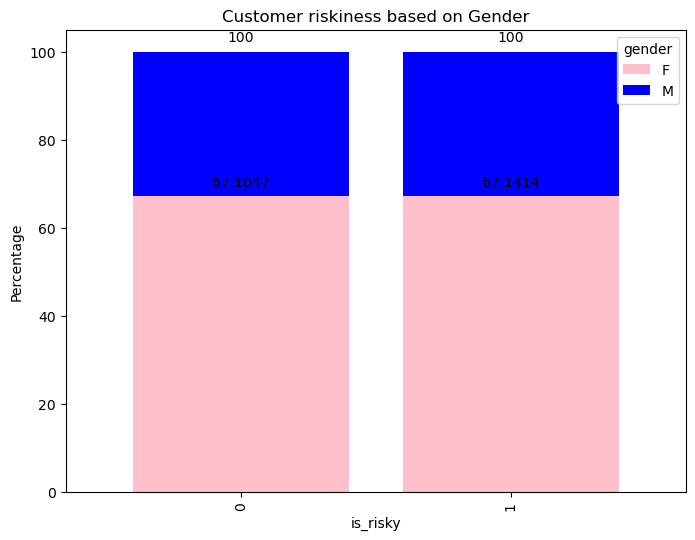

In [33]:
# create a grouped bar chart for gender and is_risky columns
grouped = application_record.groupby(['is_risky_customer', 'gender'])['ID'].count().unstack()
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100  # normalize by row

ax = grouped.plot(kind='bar', stacked=True, width=0.8, figsize=(8, 6), color=['pink', 'blue'])

# add labels and title
ax.set_xlabel('is_risky')
ax.set_ylabel('Percentage')
ax.set_title('Customer riskiness based on Gender')

# add value labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=5)

plt.show()

### Insight: 

- We normalized the data and could see that the defaultness does  not depend on the gender.

### 4.8.1.2. Has a car

In [34]:
frequency(application_record,'has_a_car')

,Count,Frequency (%)
N,275459,62.810307
Y,163098,37.189693


Does having a car (liability) affect the credit defaultness?

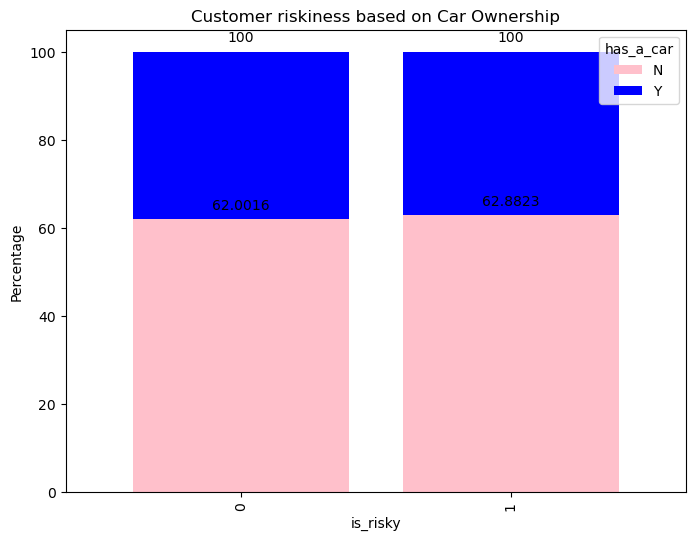

In [35]:
# create a grouped bar chart for car ownership and is_risky columns
grouped = application_record.groupby(['is_risky_customer', 'has_a_car'])['ID'].count().unstack()
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100  # normalize by row

ax = grouped.plot(kind='bar', stacked=True, width=0.8, figsize=(8, 6), color=['pink', 'blue'])

# add labels and title
ax.set_xlabel('is_risky')
ax.set_ylabel('Percentage')
ax.set_title('Customer riskiness based on Car Ownership')

# add value labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=5)

plt.show()

### Insight:
    
- Having a car does not have an affect on the defaultness.

### 4.8.1.3. Has a property

In [36]:
frequency(application_record,'has_a_property')

,Count,Frequency (%)
Y,304074,69.335115
N,134483,30.664885


Does having a property affect the credit defaultness?

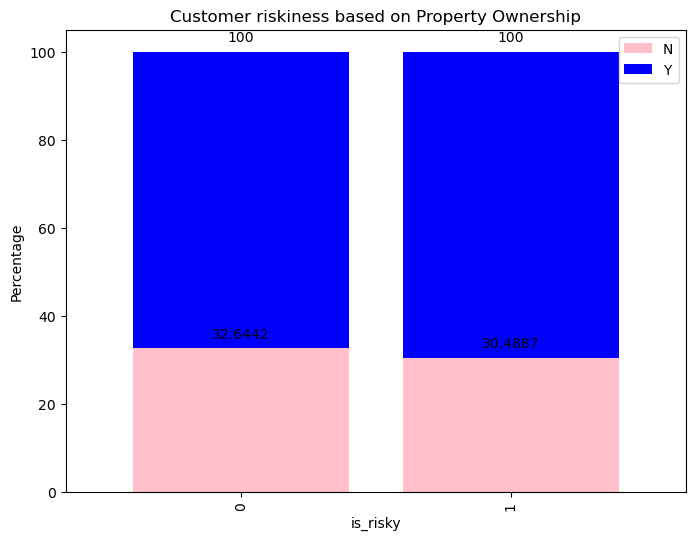

In [37]:
# create a grouped bar chart for property ownership and is_risky columns
grouped = application_record.groupby(['is_risky_customer', 'has_a_property'])['ID'].count().unstack()
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100  # normalize by row

ax = grouped.plot(kind='bar', stacked=True, width=0.8, figsize=(8, 6), color=['pink', 'blue'])

# add labels and title
ax.set_xlabel('is_risky')
ax.set_ylabel('Percentage')
ax.set_title('Customer riskiness based on Property Ownership')
# change legend position
ax.legend(loc='upper right')

# add value labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=5)

plt.show()

### Insight:

- Having a property does not have an affect on the defaultness.

### 4.8.1.4 No of children

In [38]:
frequency(application_record,'no_of_children')

,Count,Frequency (%)
0,304071,69.334431
1,88527,20.185974
2,39884,9.094371
3,5430,1.238151
4,486,0.110818
5,133,0.030327
7,9,0.002052
9,5,0.001140
12,4,0.000912
6,4,0.000912


There is an unusual entry of 19 children. Let's take a look into that.

In [39]:
application_record.loc[application_record["no_of_children"] >10]

,ID,gender,has_a_car,has_a_property,no_of_children,income,employment_status,education_level,marital_status,housing,age,employment_length,has_a_mobile,has_a_workphone,has_a_phone,has_an_email,job_title,family_member_count,is_risky_customer
20441,5061207,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,1,0,0,0,Drivers,15.0,0
20442,5061210,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,1,0,0,0,Drivers,15.0,0
20443,5061211,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,1,0,0,0,Drivers,15.0,0
36388,5105054,F,N,Y,19,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-11057,-1853,1,1,1,0,Waiters/barmen staff,20.0,0
208909,5931568,F,N,Y,12,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14093,-2710,1,0,0,0,Core staff,14.0,1
208910,5931569,F,N,Y,12,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14093,-2710,1,0,0,0,Core staff,14.0,1
208911,5931570,F,N,Y,12,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14093,-2710,1,0,0,0,Core staff,14.0,1
208912,5931571,F,N,Y,12,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14093,-2710,1,0,0,0,Core staff,14.0,1


Having 19 children is an unusual for a 30 years old. This might skew our results. We would remove this value from our analysis.

In [40]:
application_record = application_record[application_record["no_of_children"] != 19]

In [41]:
# copy data
kids = application_record[["no_of_children","is_risky_customer"]]

# crete_has_children column
kids["has_child"] = kids["no_of_children"].apply(lambda i: 1 if i>0 else 0)

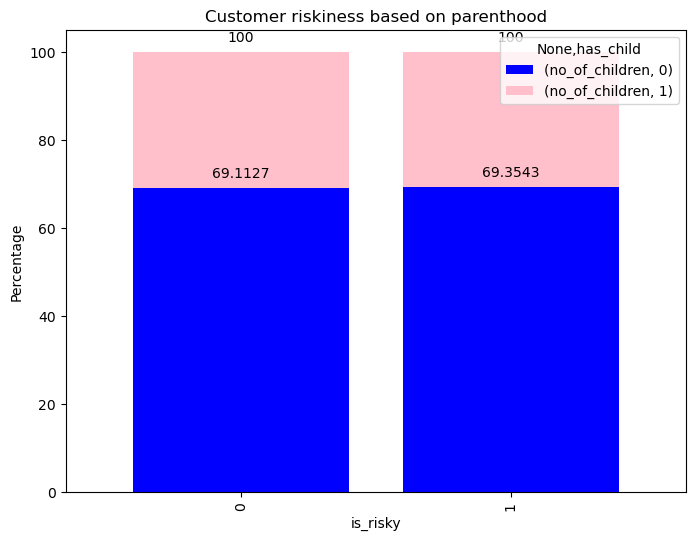

In [42]:
# create a grouped bar chart for parenthood and is_risky columns
grouped = kids.groupby(['is_risky_customer', 'has_child']).count().unstack()
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100  # normalize by row

ax = grouped.plot(kind='bar', stacked=True, width=0.8, figsize=(8, 6), color=['blue', 'pink'])

# add labels and title
ax.set_xlabel('is_risky')
ax.set_ylabel('Percentage')
ax.set_title('Customer riskiness based on parenthood')

# add value labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=5)

plt.show()

### Insight:

- Having kids does not linearly affect the riskiness of the customer.

### 4.8.1.6. Employment status

In [43]:
frequency(application_record,'employment_status')

,Count,Frequency (%)
Working,226103,51.556244
Commercial associate,100757,22.974717
Pensioner,75493,17.213993
State servant,36186,8.251170
Student,17,0.003876


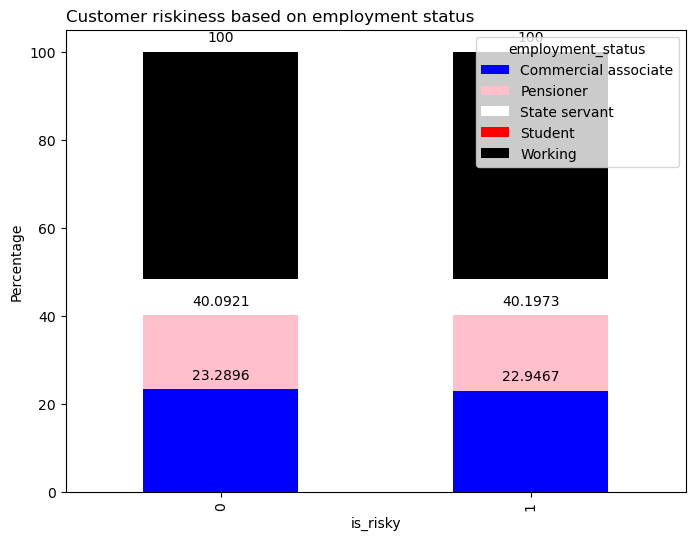

In [44]:
# create a grouped bar chart for parenthood and is_risky columns
grouped = application_record.groupby(['is_risky_customer', 'employment_status'])["ID"].count().unstack()
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100  # normalize by row

ax = grouped.plot(kind='bar', stacked=True, width=0.5, figsize=(8, 6), color=['blue', 'pink', 'white','red','black'])

# add labels and title
ax.set_xlabel('is_risky')
ax.set_ylabel('Percentage')
ax.set_title('Customer riskiness based on employment status', loc="left")

# add value labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=5)

plt.show()

### Insights:

- All the employment status categories has same chance at being defaultness.

### 4.8.1.7. Education_level

In [45]:
frequency(application_record,'education_level')

,Count,Frequency (%)
Secondary / secondary special,301820,68.821314
Higher education,117522,26.797490
Incomplete higher,14851,3.386341
Lower secondary,4051,0.923713
Academic degree,312,0.071143


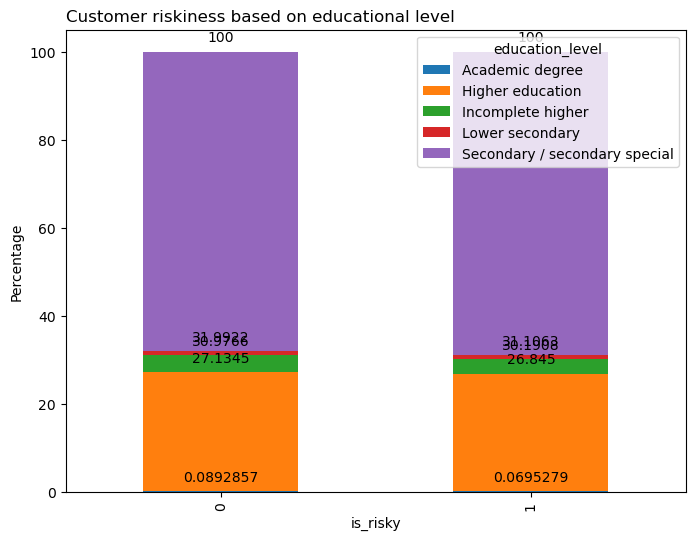

In [46]:
# create a grouped bar chart for educational level and is_risky columns
grouped = application_record.groupby(['is_risky_customer', 'education_level'])["ID"].count().unstack()
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100  # normalize by row

ax = grouped.plot(kind='bar', stacked=True, width=0.5, figsize=(8, 6))

# add labels and title
ax.set_xlabel('is_risky')
ax.set_ylabel('Percentage')
ax.set_title('Customer riskiness based on educational level', loc="left")

# add value labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=5)

plt.show()

### Insights:

- All the educational level categories has same chance at being defaultness.

### 4.8.1.8. Marital Status

In [47]:
frequency(application_record,'marital_status')

,Count,Frequency (%)
Married,299828,68.367096
Single / not married,55270,12.602723
Civil marriage,36532,8.330065
Separated,27251,6.213802
Widow,19675,4.486314


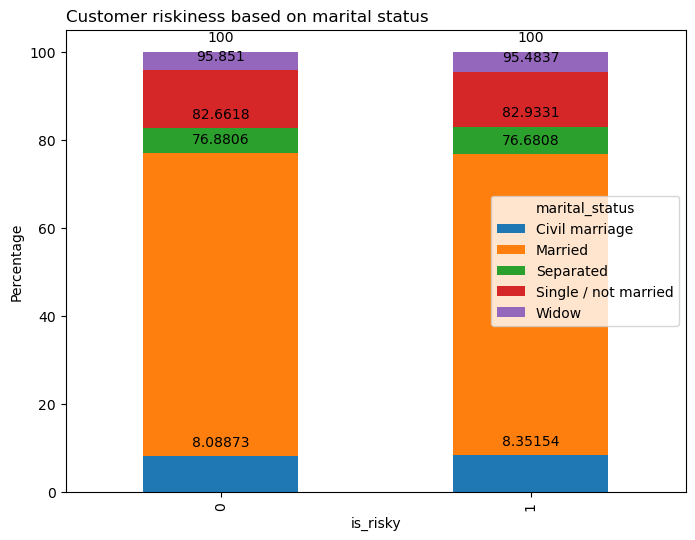

In [48]:
# create a grouped bar chart for educational level and is_risky columns
grouped = application_record.groupby(['is_risky_customer', 'marital_status'])["ID"].count().unstack()
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100  # normalize by row

ax = grouped.plot(kind='bar', stacked=True, width=0.5, figsize=(8, 6))

# add labels and title
ax.set_xlabel('is_risky')
ax.set_ylabel('Percentage')
ax.set_title('Customer riskiness based on marital status', loc="left")

# add value labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=5)

plt.show()

### Insights:

- All the marital level categories has same chance at being defaultness.

### 4.8.1.9 Housing

In [49]:
frequency(application_record,'housing')

,Count,Frequency (%)
House / apartment,393830,89.801530
With parents,19077,4.349958
Municipal apartment,14214,3.241091
Rented apartment,5974,1.362198
Office apartment,3922,0.894299
Co-op apartment,1539,0.350924


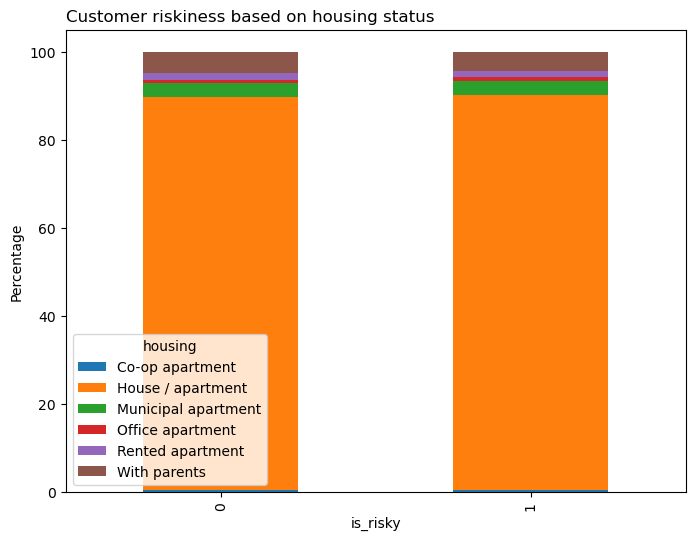

In [50]:
# create a grouped bar chart for educational level and is_risky columns
grouped = application_record.groupby(['is_risky_customer', 'housing'])["ID"].count().unstack()
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100  # normalize by row

ax = grouped.plot(kind='bar', stacked=True, width=0.5, figsize=(8, 6),)

# add labels and title
ax.set_xlabel('is_risky')
ax.set_ylabel('Percentage')
ax.set_title('Customer riskiness based on housing status', loc="left")

plt.show()

### Insights:

- All the housing level categories has same chance at being defaultness.

### 4.8.1.10 Age

In [51]:
# change age to years

application_record['age'] = round((abs(application_record['age'])//365.0))
application_record.head()

,ID,gender,has_a_car,has_a_property,no_of_children,income,employment_status,education_level,marital_status,housing,age,employment_length,has_a_mobile,has_a_workphone,has_a_phone,has_an_email,job_title,family_member_count,is_risky_customer
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.0,-4542,1,1,0,0,Unknown,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.0,-4542,1,1,0,0,Unknown,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,58.0,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.0,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.0,-3051,1,0,1,1,Sales staff,1.0,0


In [52]:
application_record['age'].min(),application_record['age'].max()

(20.0, 69.0)

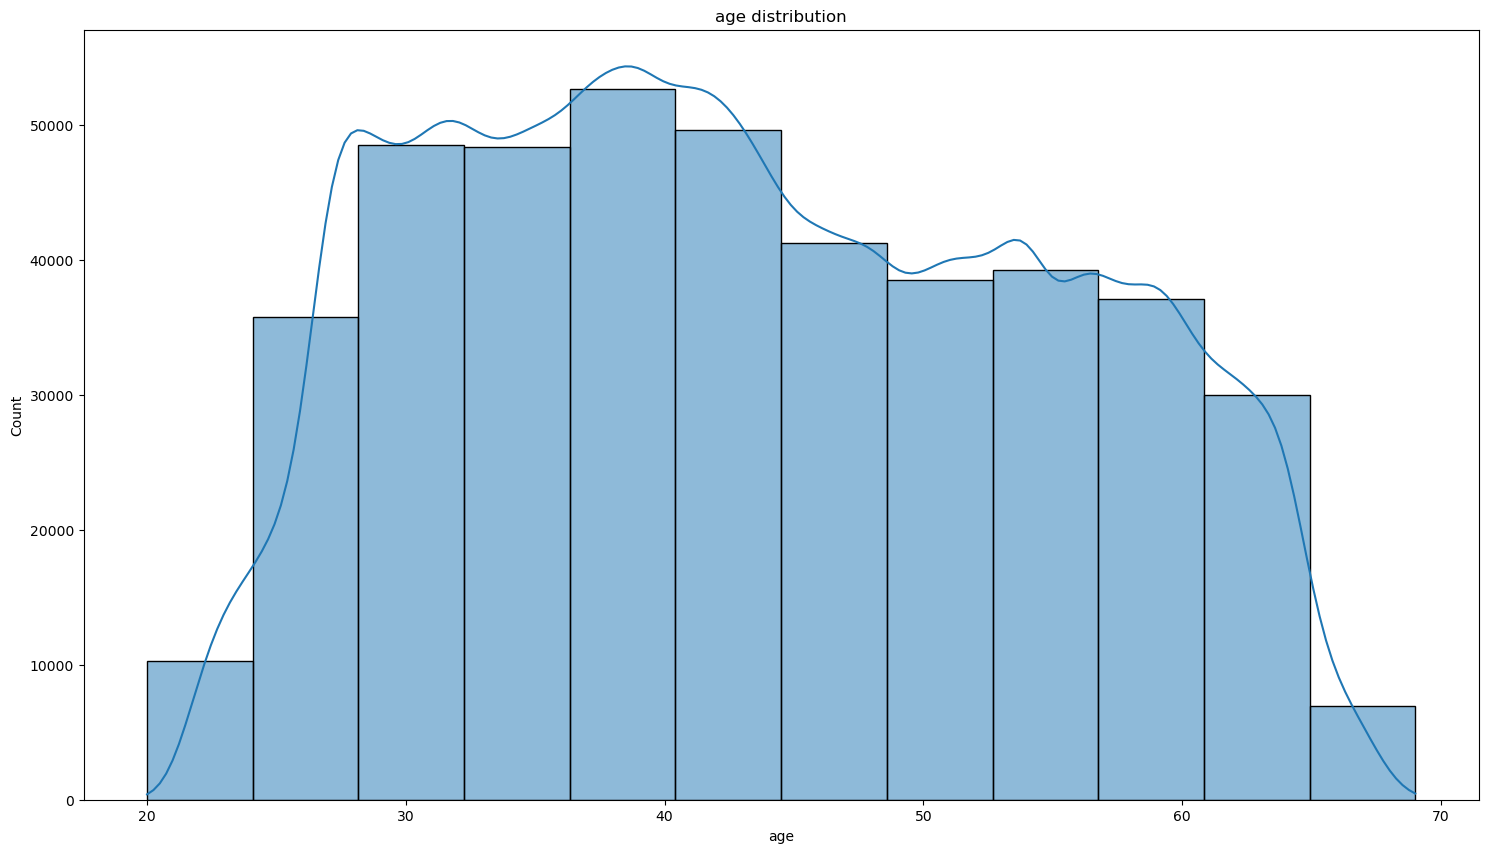

In [53]:
# histogram

fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(application_record["age"], bins = 12, kde=True)
# suppress scientific notation
plt.title('{} distribution'.format("age"))
plt.show()


<AxesSubplot:xlabel='age', ylabel='Count'>

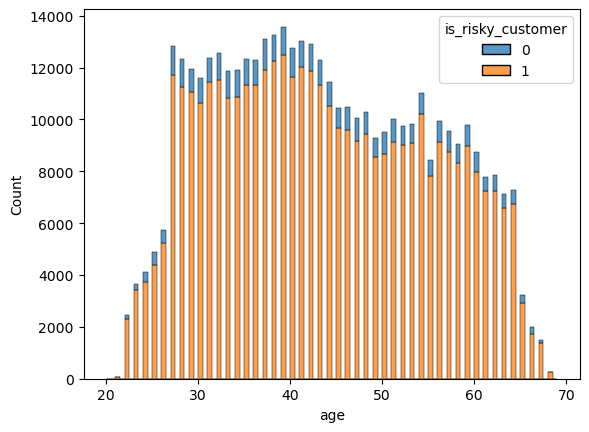

In [54]:
sns.histplot(data=application_record, x="age", hue="is_risky_customer", multiple="stack")

### Does age affects the riskiness of customers?

Text(0.5, 1.0, 'Age by customer riskiness')

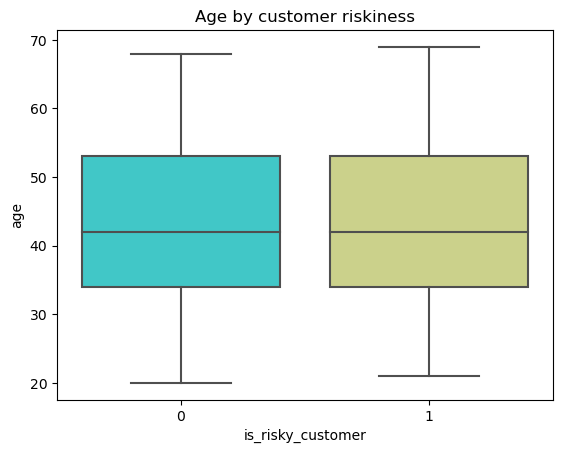

In [55]:
#plt.figure(figsize=(8,5))
sns.boxplot(x='is_risky_customer',y='age',data=application_record, palette='rainbow')
plt.title("Age by customer riskiness")

### Insights:

- All the age bars are normal distributed.

### 4.8.1.11. employement length

Let's check the employement length analysis. The positive days mean the applicant is unemployed.

In [56]:
application_record[application_record['employment_length']>0]

,ID,gender,has_a_car,has_a_property,no_of_children,income,employment_status,education_level,marital_status,housing,age,employment_length,has_a_mobile,has_a_workphone,has_a_phone,has_an_email,job_title,family_member_count,is_risky_customer
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,61.0,365243,1,0,0,0,Unknown,1.0,0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,61.0,365243,1,0,0,0,Unknown,1.0,0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,61.0,365243,1,0,0,0,Unknown,1.0,0
76,5008884,F,N,Y,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,55.0,365243,1,0,0,0,Unknown,1.0,0
160,5008974,F,N,Y,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,61.0,365243,1,0,0,0,Unknown,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438549,6840098,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,62.0,365243,1,0,0,0,Unknown,1.0,1
438550,6840100,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,62.0,365243,1,0,0,0,Unknown,1.0,1
438551,6840102,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,62.0,365243,1,0,0,0,Unknown,1.0,1
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,62.0,365243,1,0,0,0,Unknown,1.0,1


All the pensioners have same huge positive employment length in the data. To impute the data for this case, we would replace the employement_length simply with age - 18, assuming the person must have started working at the age of 18.  

In [57]:
condition = application_record['employment_length']>0

In [58]:
application_record.loc[condition, 'employment_length'] = (application_record['age'] - 18) 

In [59]:
condition = application_record['employment_length']<0

In [60]:
# change employement_length to years
application_record.loc[condition, 'employment_length'] = round((abs(application_record['employment_length'])/365.0),2)
application_record['employment_length'] = application_record['employment_length'].apply(np.ceil)
application_record.head()

,ID,gender,has_a_car,has_a_property,no_of_children,income,employment_status,education_level,marital_status,housing,age,employment_length,has_a_mobile,has_a_workphone,has_a_phone,has_an_email,job_title,family_member_count,is_risky_customer
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.0,13.0,1,1,0,0,Unknown,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.0,13.0,1,1,0,0,Unknown,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,58.0,4.0,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.0,9.0,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.0,9.0,1,0,1,1,Sales staff,1.0,0


In [61]:
application_record["employment_length"].min()

1.0

In [62]:
application_record["employment_length"].max()

51.0

In [63]:
frequency(application_record,'employment_length')

,Count,Frequency (%)
2.0,38751,8.836044
3.0,37491,8.548737
1.0,33751,7.695938
4.0,33449,7.627076
5.0,30905,7.046991
6.0,24202,5.518565
7.0,23611,5.383805
8.0,21728,4.954441
9.0,19233,4.385529
10.0,15227,3.472077


In [64]:
application_record['employment_length'].max()

51.0

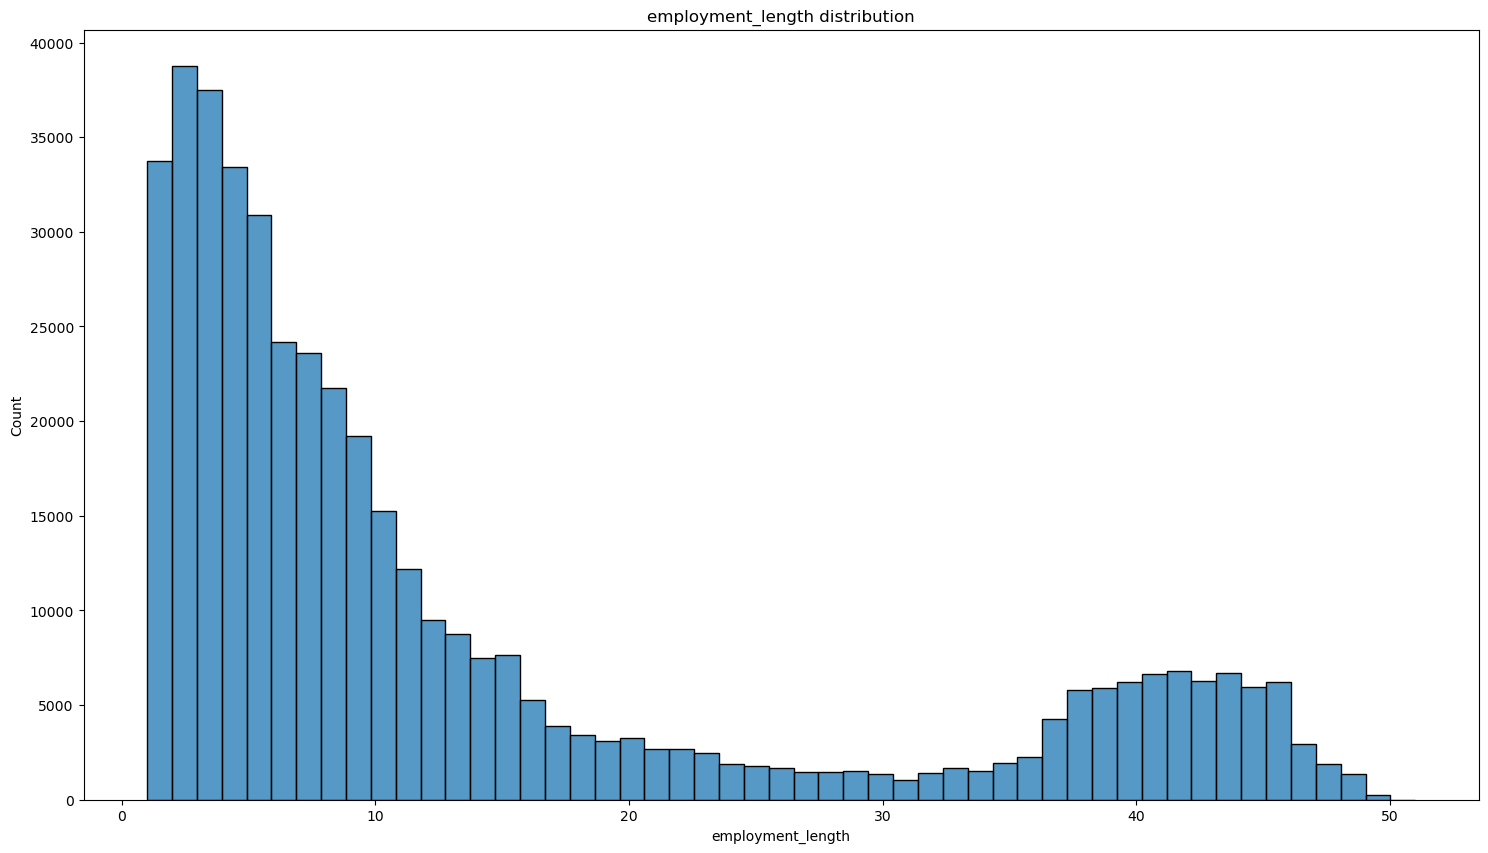

In [65]:
# histogram

fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(application_record["employment_length"], bins = 51)
# suppress scientific notation
plt.title('{} distribution'.format("employment_length"))
plt.show()


### Insights:

- The data is skewed.

### 4.8.1.12. Workphone

In [66]:
frequency(application_record,'has_a_workphone')

,Count,Frequency (%)
0,348156,79.386897
1,90400,20.613103


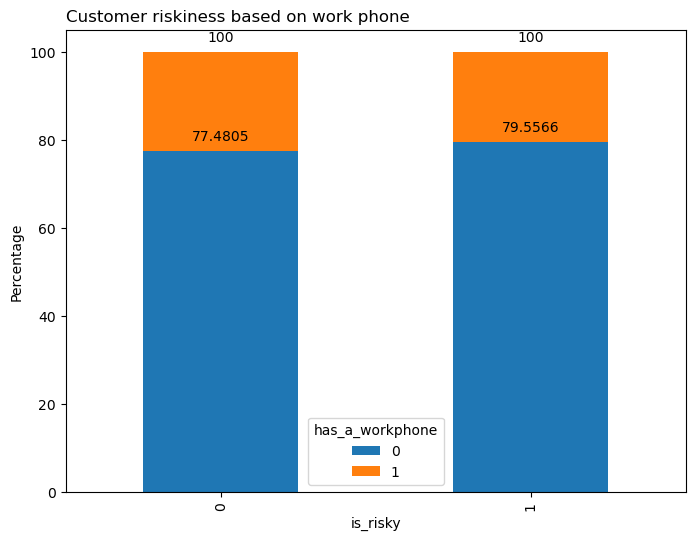

In [67]:
# create a grouped bar chart for work phone and is_risky columns
grouped = application_record.groupby(['is_risky_customer', 'has_a_workphone'])["ID"].count().unstack()
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100  # normalize by row

ax = grouped.plot(kind='bar', stacked=True, width=0.5, figsize=(8, 6))

# add labels and title
ax.set_xlabel('is_risky')
ax.set_ylabel('Percentage')
ax.set_title('Customer riskiness based on work phone', loc="left")

# add value labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=5)

plt.show()

### Insights:

- Having a workphone has same distribution in riskiness of workphone.

### 4.8.1.13. Phone

In [68]:
univariate_categorical(application_record,'has_a_phone')

Description:
count    438556.000000
mean          0.287769
std           0.452724
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: has_a_phone, dtype: float64
**************************************************
Value count:
    Count  Frequency (%)
0  312353      71.223059
1  126203      28.776941


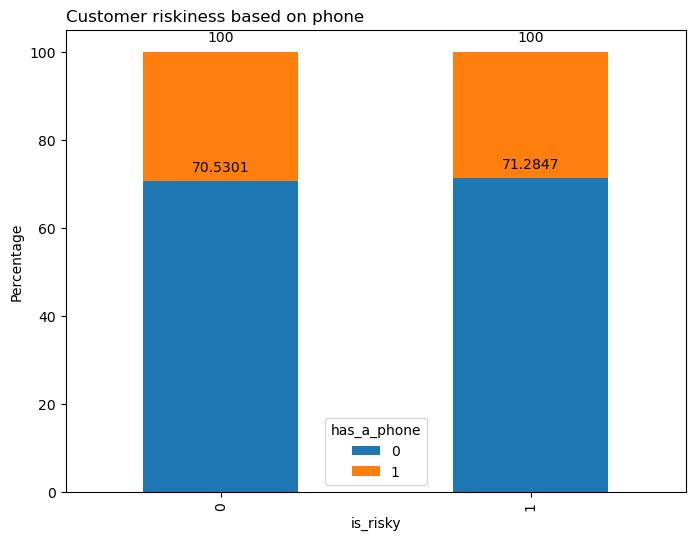

In [69]:
# create a grouped bar chart for phone and is_risky columns
grouped = application_record.groupby(['is_risky_customer', 'has_a_phone'])["ID"].count().unstack()
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100  # normalize by row

ax = grouped.plot(kind='bar', stacked=True, width=0.5, figsize=(8, 6))

# add labels and title
ax.set_xlabel('is_risky')
ax.set_ylabel('Percentage')
ax.set_title('Customer riskiness based on phone', loc="left")

# add value labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=5)

plt.show()

### Insights:

- Having a workphone has same distribution in riskiness of phone.

### 4.8.1.14. Job-title

Adding the category of pensioner based on the employement type to the data

In [70]:
application_record['job_title'][(application_record.job_title == 'Unknown') & (application_record.employment_status =="Pensioner")] = "Pensioner"

<AxesSubplot:>

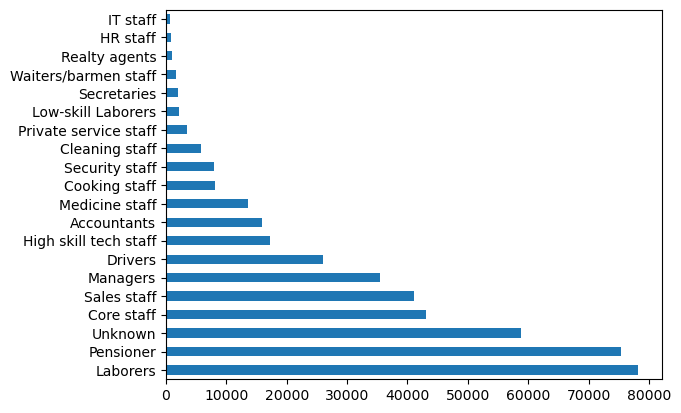

In [71]:
application_record["job_title"].value_counts().plot(kind = "barh")

In [72]:
frequency(application_record,'is_risky_customer')

,Count,Frequency (%)
1,402716,91.827726
0,35840,8.172274


### 4.8.1.15 Income

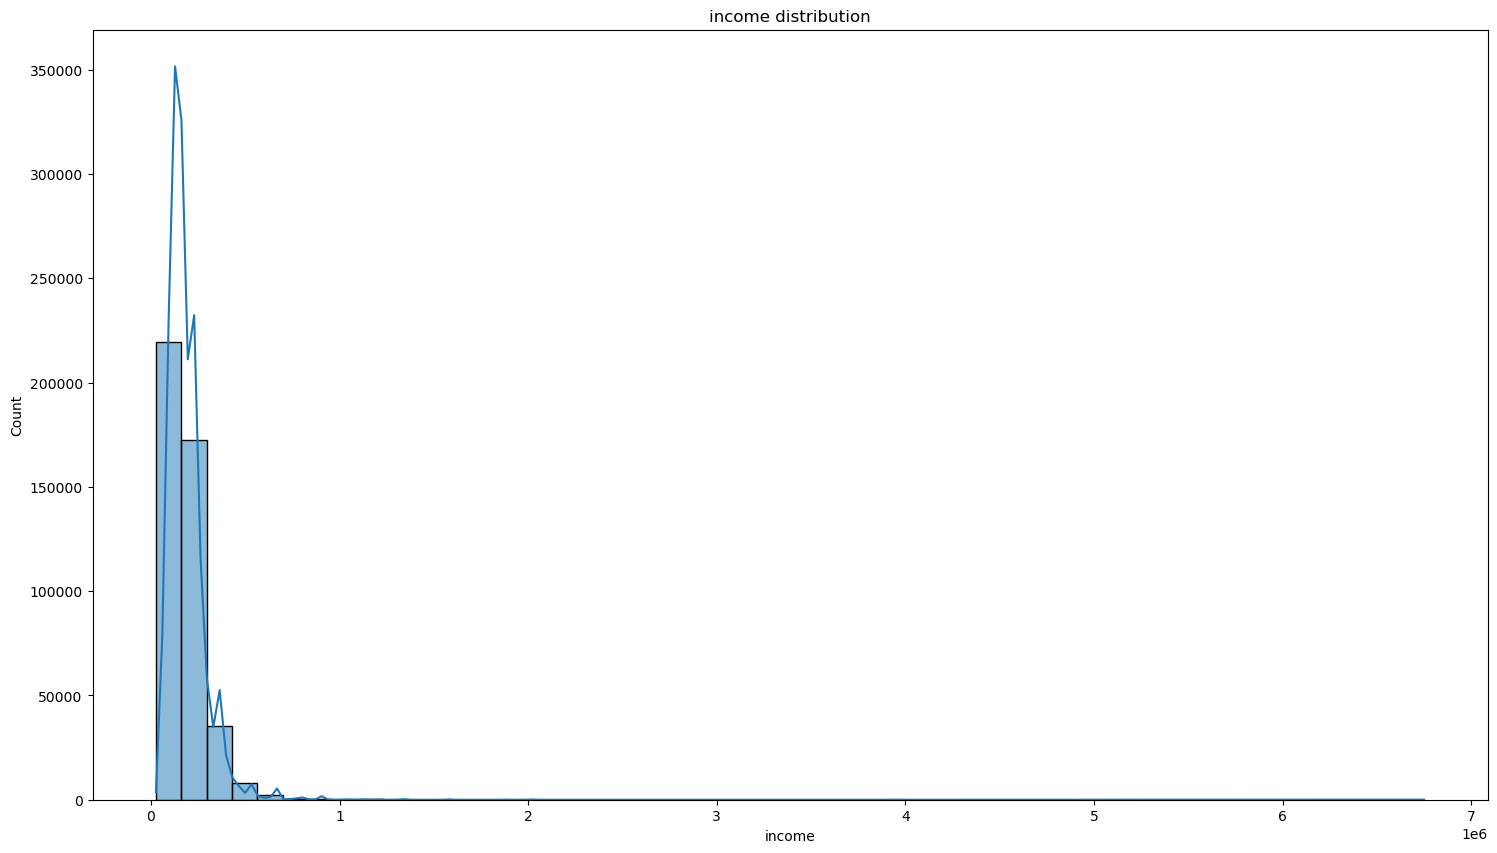

In [73]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(application_record["income"], bins = 50, kde=True)
# suppress scientific notation
plt.title('{} distribution'.format("income"))
plt.show()


### Insights:

- Our data is left skewed.

In [74]:
pt = PowerTransformer()
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')



x = qt.fit_transform(X = np.array(application_record[["income","employment_length"]]), y= None)

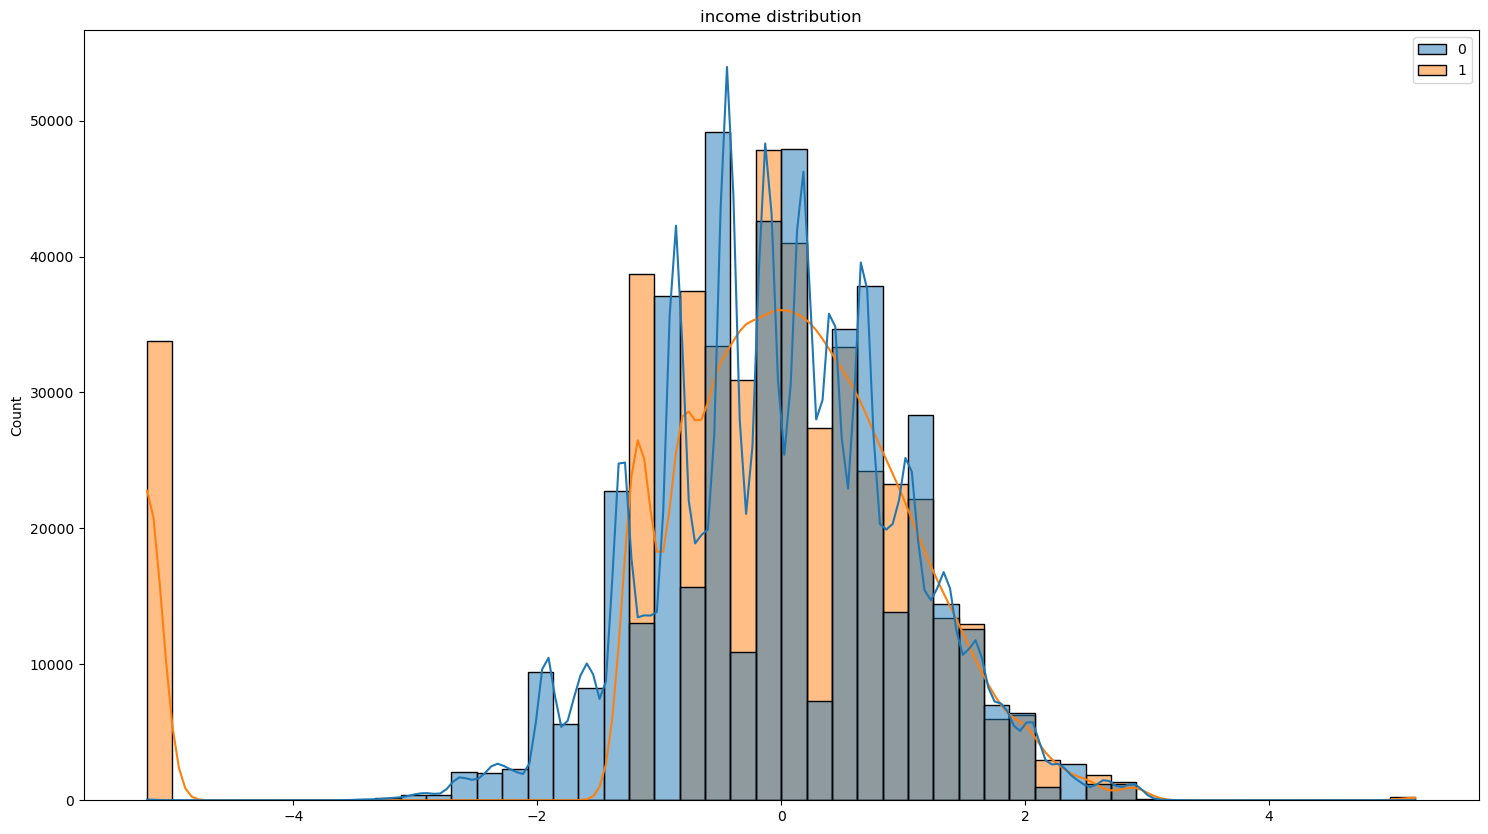

In [75]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(x, bins = 50, kde=True)
# suppress scientific notation
plt.title('{} distribution'.format("income"))
plt.show()


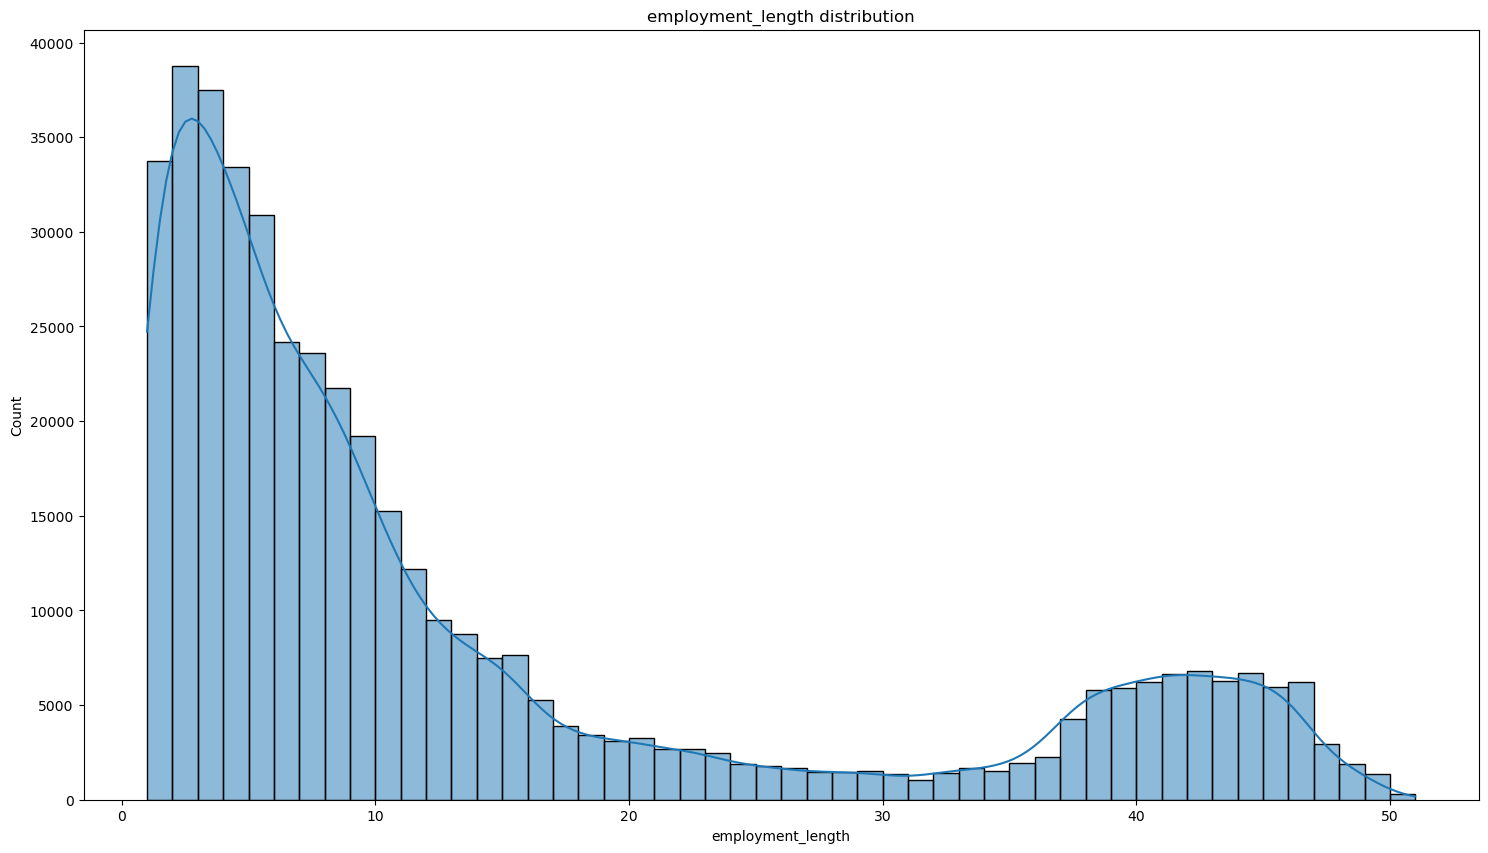

In [76]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(application_record["employment_length"], bins = 50, kde=True)
# suppress scientific notation
plt.title('{} distribution'.format("employment_length"))
plt.show()


In [77]:

x = qt.fit_transform(X = np.array(application_record["employment_length"]).reshape(-1, 1), y= None)

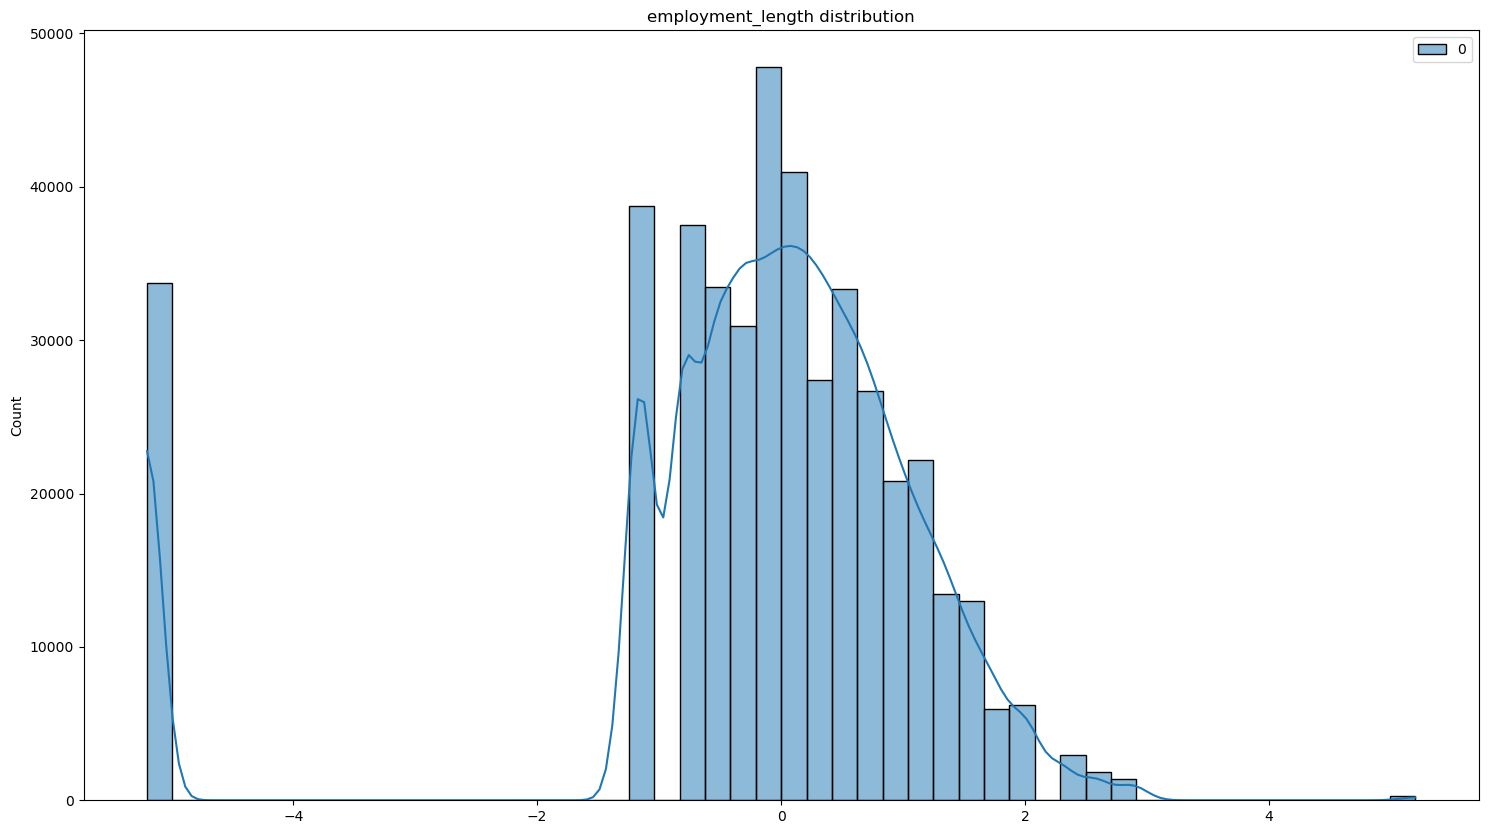

In [78]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(x, bins = 50, kde=True)
# suppress scientific notation
plt.title('{} distribution'.format("employment_length"))
plt.show()

In [79]:
y = pt.fit_transform(X = np.array(application_record["employment_length"]).reshape(-1, 1), y= None)

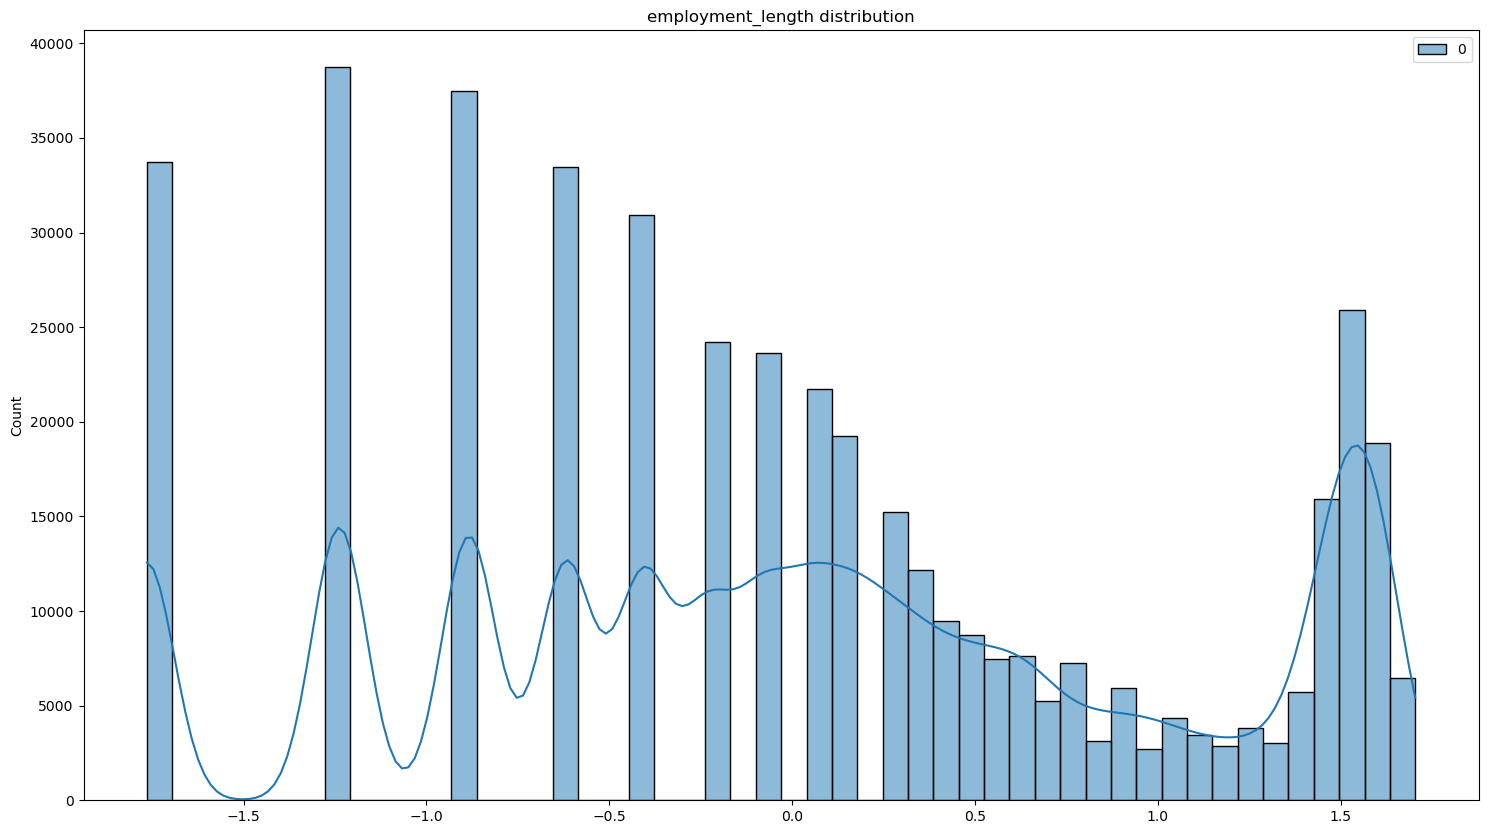

In [80]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(y, bins = 50, kde=True)
# suppress scientific notation
plt.title('{} distribution'.format("employment_length"))
plt.show()

### Most applied applicant's Job-title

<AxesSubplot:>

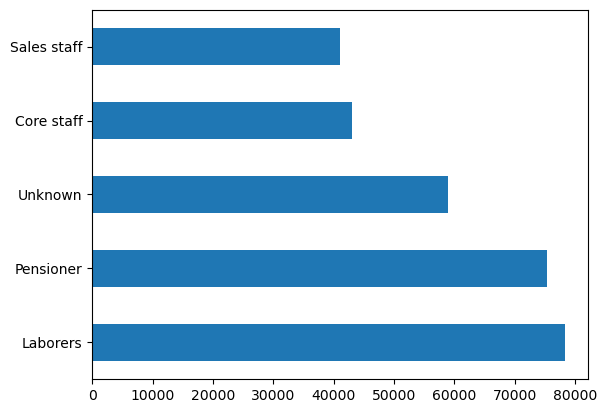

In [81]:
application_record["job_title"].value_counts()[:5].plot(kind = "barh")

### Top 5 Job title who go default on their payments

<AxesSubplot:>

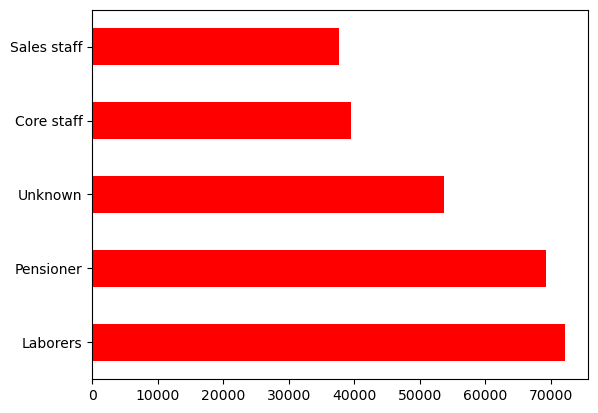

In [82]:
application_record[application_record["is_risky_customer"] == 1]["job_title"].value_counts()[:5].plot(kind = "barh", color="red")

In [83]:
risky_profession = pd.DataFrame(application_record[application_record["is_risky_customer"] == 1].groupby(['job_title'])["ID"].
                                count().reset_index())

In [84]:
risky_profession.sort_values(by = "ID", ascending=False)

,job_title,ID
8,Laborers,72128
12,Pensioner,69335
18,Unknown,53739
3,Core staff,39490
15,Sales staff,37658
10,Managers,32522
4,Drivers,24001
6,High skill tech staff,15936
0,Accountants,14767
11,Medicine staff,12323


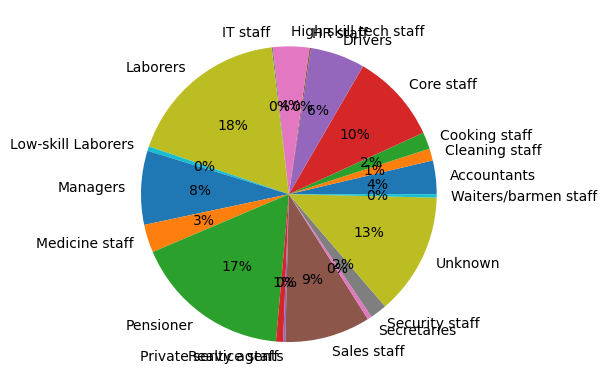

In [85]:
plt.pie(risky_profession["ID"], labels = risky_profession["job_title"], autopct='%1.0f%%')

plt.show() 

### Insights:

- Laborers, Pensioners are the top risky professions for credit card companies by making up to 35% of the overall defaulters.
- This is followed by Core staff, Sales Staff, And Managers.

### Safe job-title for a credit card company

In [86]:
safe_profession = pd.DataFrame(application_record[application_record["is_risky_customer"] == 0].groupby(['job_title'])["ID"].
                                count().reset_index())

In [87]:
safe_profession.sort_values(by = "ID", ascending=False)

,job_title,ID
8,Laborers,6112
12,Pensioner,6022
18,Unknown,5107
3,Core staff,3517
15,Sales staff,3440
10,Managers,2965
4,Drivers,2089
6,High skill tech staff,1353
0,Accountants,1218
11,Medicine staff,1197


We see the same professions in this category too. We will further investigate this by using more features.

### Insights: 

- We have almost double the data of female applicants than male.
- Almost 40% of the applicants don't have a car.
- Almost 70% applicants do have a property.
- All the applicants have mobile.
- Majority of our applicants are from working background. Surprisingly, pensioner are also in a significant amount, almost a third of working applicants.
- Majority of applicant come from secondary education level and almost 25% applicants are from higher education.
- Almost 70% applicants are married.
- 90% of the applicants have their own house.
- The min age we have in applicants is 21 and max is 69. 
- We have more applicants in 30-45 age group. We have least applicants in the young age, 21-25.
- 80% of applicants have workphone
- The employement length data is skewed.
- We still have a majority of Other and pensioner applicants.
- The only clear relation we could see in the data would be between number of children and family size.

## Bivariate Analysis

### 1. Age vs the rest of categorical features

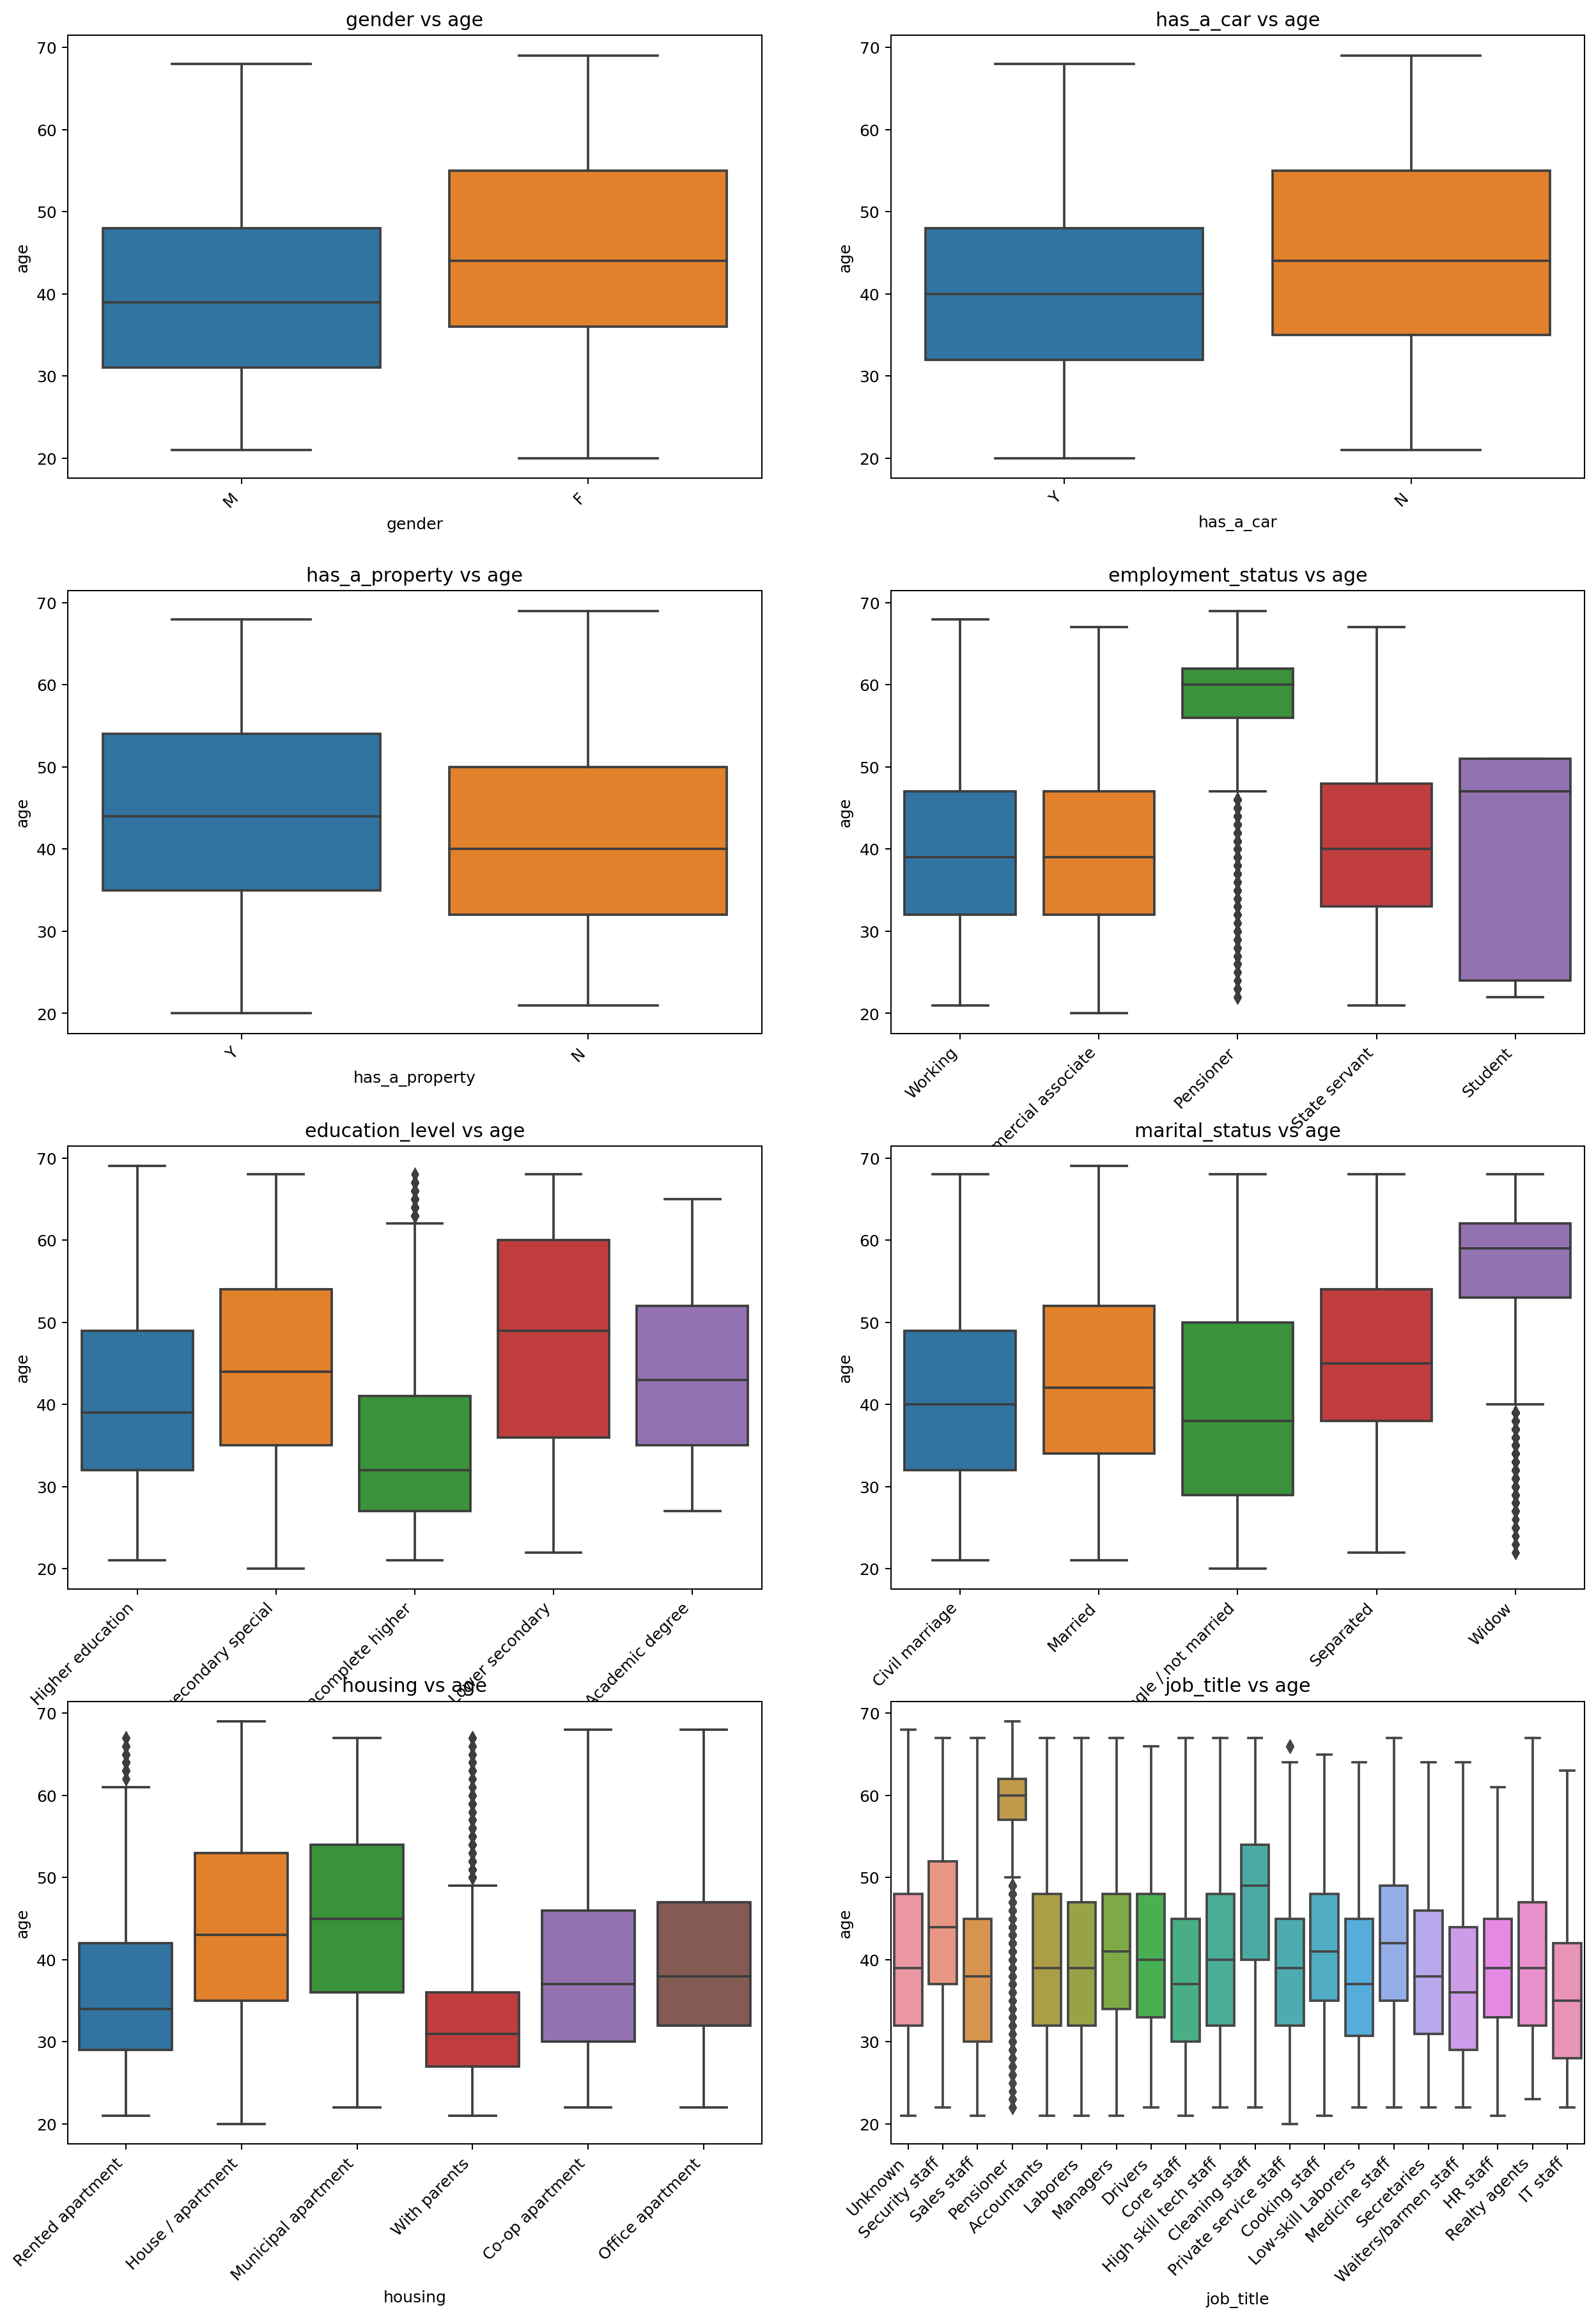

In [88]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['gender', 'has_a_car', 'has_a_property', 'employment_status', 'education_level', 'marital_status', 'housing', 'job_title']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=application_record[cat_features[cat_ft_count]],y=application_record['age'])
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('age')
            cat_ft_count += 1
    break

From above we can say,
1. The female applicants start applying at the later stage of life then men.
2. There are young pansioners present(might be from military or service)
3. Some of the older folks stay with their parents.
4. Cleaning staff and security staff see more older folks.

### 2. Income vs the rest of categorical features

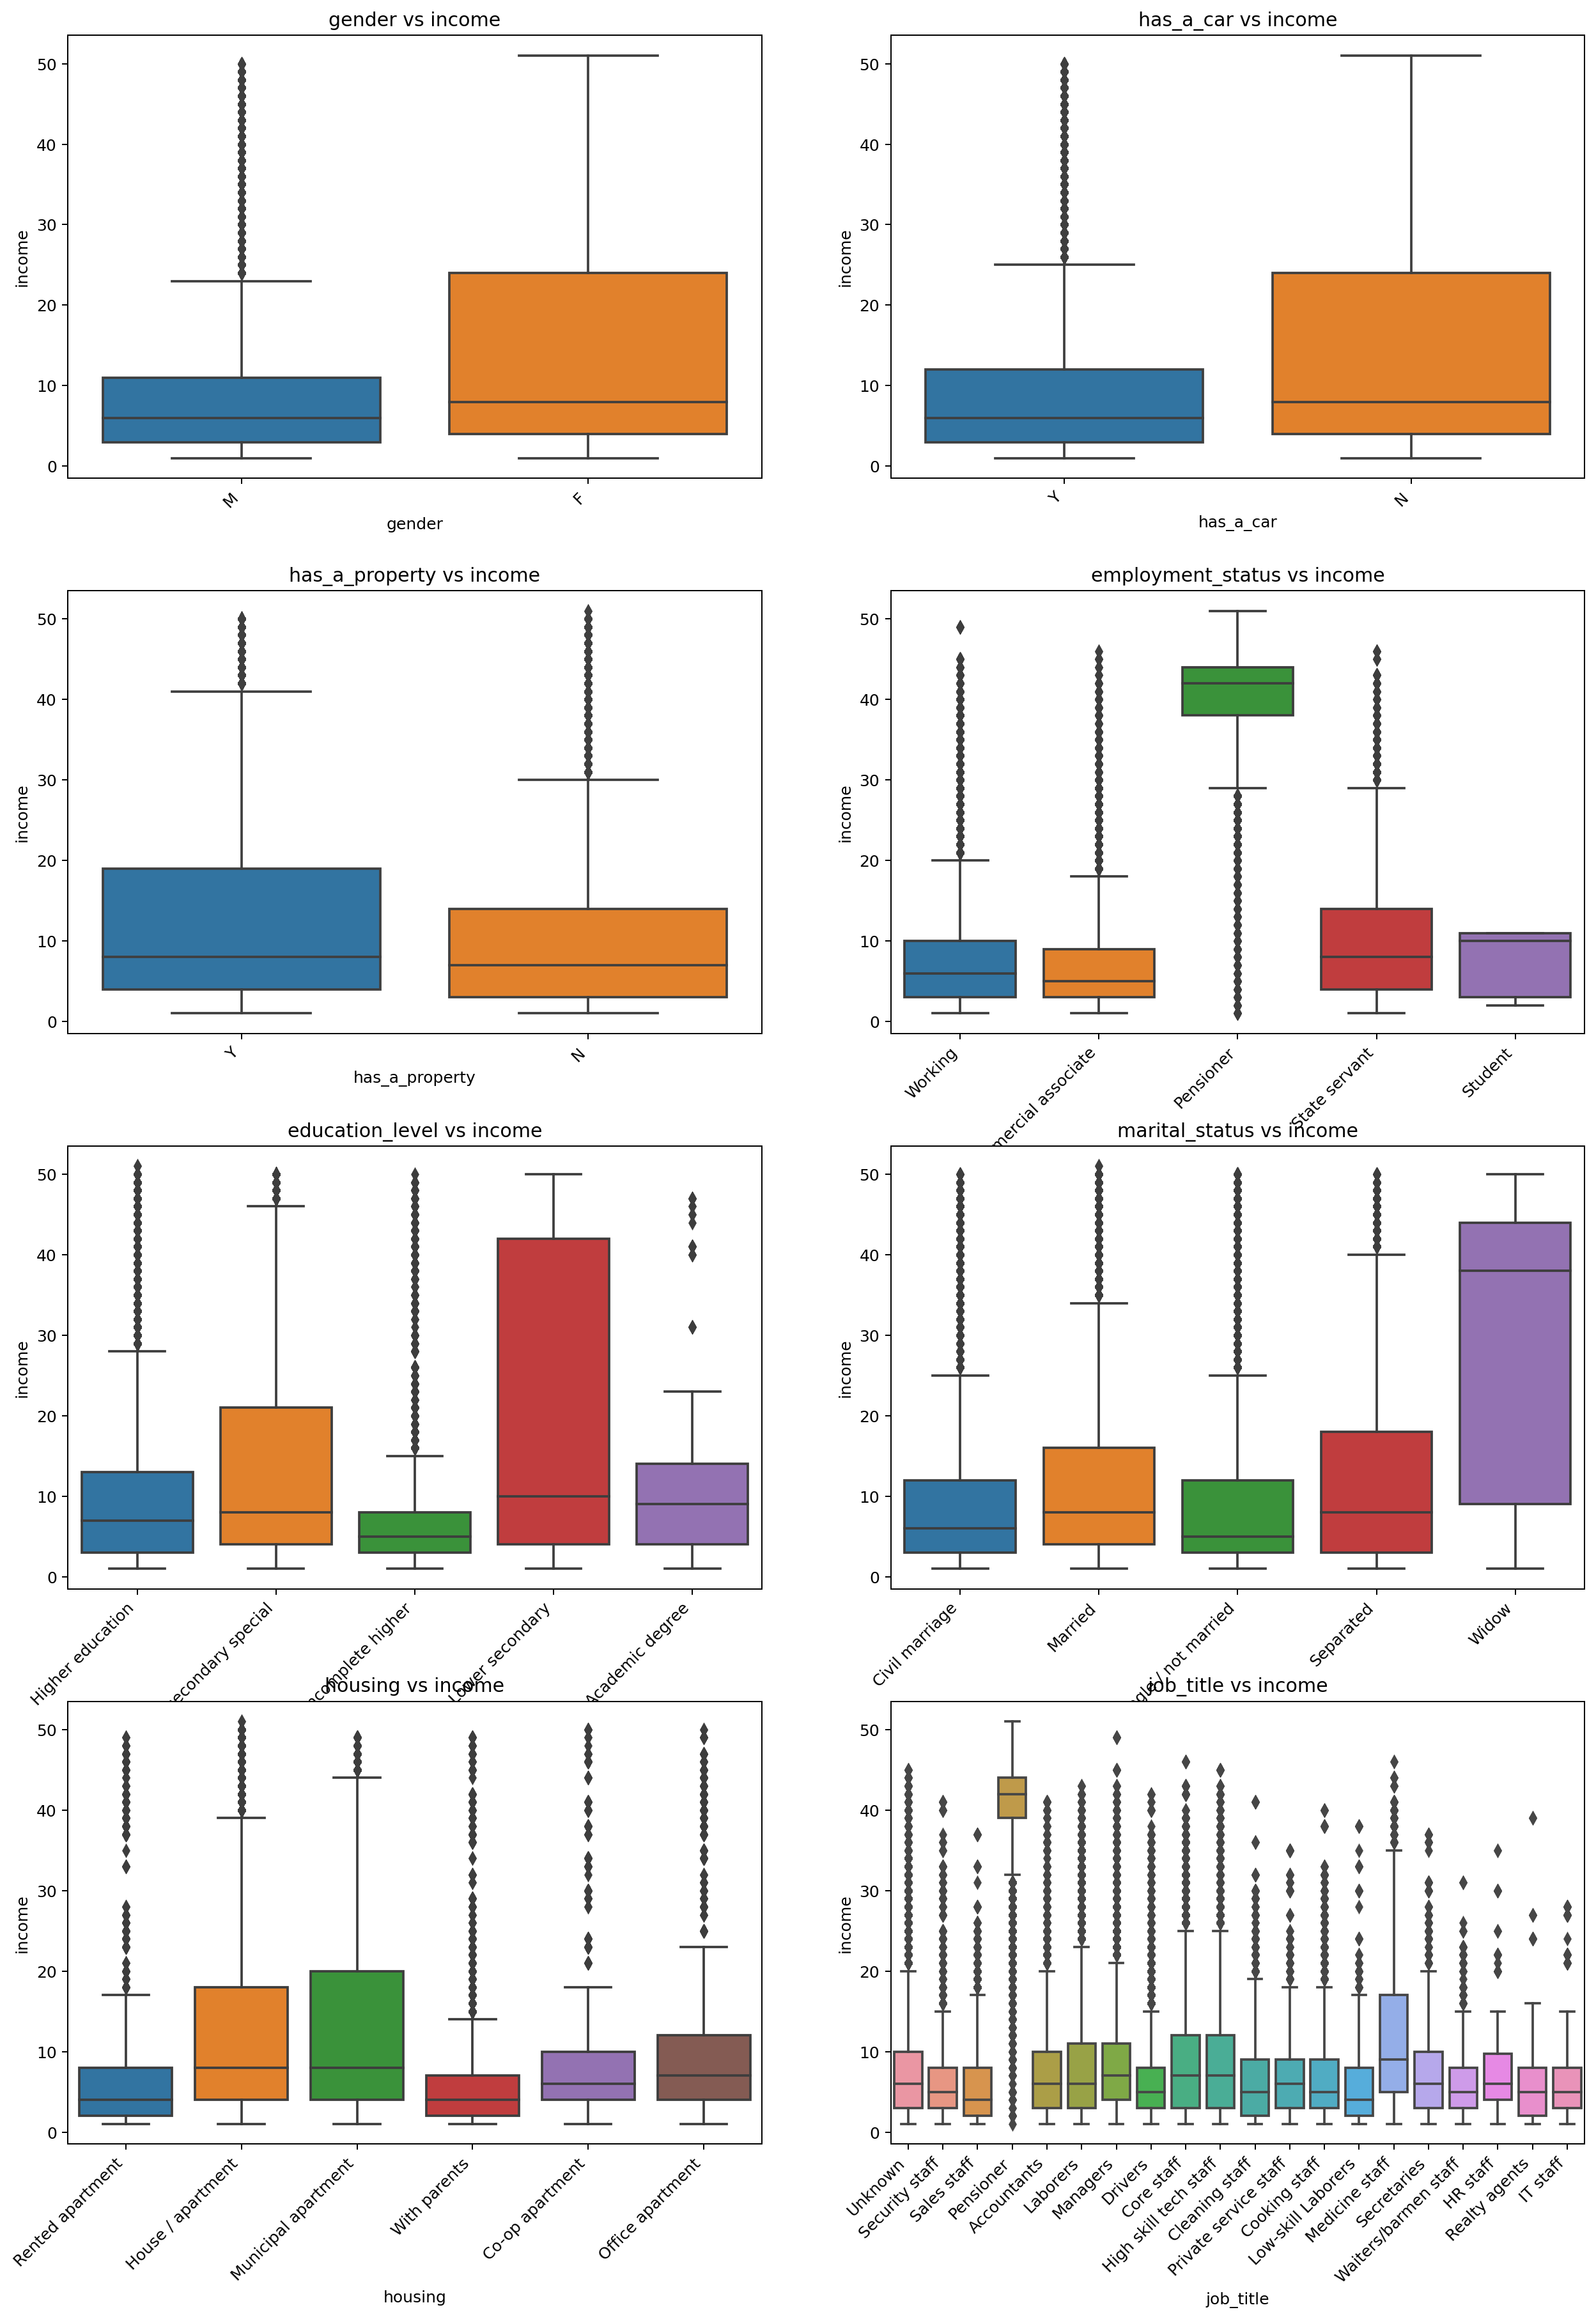

In [89]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=application_record[cat_features[cat_ft_count]],y=application_record['employment_length'])
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs income")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('income')
            cat_ft_count += 1
    break

### Correlation between target variable with other features

In [90]:
application_record.corr(method = 'pearson')

,ID,no_of_children,income,age,employment_length,has_a_mobile,has_a_workphone,has_a_phone,has_an_email,family_member_count,is_risky_customer
ID,1.000000,-0.005088,0.011176,0.005089,0.002141,NaN,-0.023312,-0.018986,0.032874,-0.001791,0.492669
no_of_children,-0.005088,1.000000,0.019231,-0.349198,-0.251452,NaN,0.038332,-0.038387,0.028498,0.884681,-0.001021
income,0.011176,0.019231,1.000000,-0.053867,-0.123894,NaN,-0.033632,0.004447,0.112139,0.011490,0.002229
age,0.005089,-0.349198,-0.053867,1.000000,0.695150,NaN,-0.171945,0.037851,-0.096705,-0.306209,0.001655
employment_length,0.002141,-0.251452,-0.123894,0.695150,1.000000,NaN,-0.202145,0.023982,-0.086627,-0.235360,0.000572
has_a_mobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_a_workphone,-0.023312,0.038332,-0.033632,-0.171945,-0.202145,NaN,1.000000,0.290061,-0.060913,0.049711,-0.014059
has_a_phone,-0.018986,-0.038387,0.004447,0.037851,0.023982,NaN,0.290061,1.000000,-0.001169,-0.024295,-0.004566
has_an_email,0.032874,0.028498,0.112139,-0.096705,-0.086627,NaN,-0.060913,-0.001169,1.000000,0.022080,0.017662
family_member_count,-0.001791,0.884681,0.011490,-0.306209,-0.235360,NaN,0.049711,-0.024295,0.022080,1.000000,-0.001400


In [91]:
application_record.to_csv("data//application_record_transformed.csv", sep=',', encoding='utf-8')

## The target variable has no significant correlation with the features. The only significant relation is between number of children and family member counts. Age and number of children also seem to have negative correlation.

# Data Preprosessing

- ID : Drop the column

- Gender: One hot coding.
    
- has_a_car: Transform Y -> 1 and N -> 0
    
- has_a_property : Transform Y -> 1 and N -> 0

- no_of_children: Remove outliers
    
- income : Clipping and binning of the data 

- employment_status: Convert categorical variable by one hot coding.
    
- education_level: This is an ordinal variable. Map it into the integer order.
    
- marital_status : One hot coding. 
    
- housing : One hot coding.   
    
- age : Binning of the data        
    
- employment_length : Binning of the data

- family_member_count : Drop this feature. It is highly dependent ob the no_of_childern.


The feature ID does not hold significant importance. We would drop this in our analysis.

In [92]:
application_record = application_record.drop(['ID'], axis=1)

Gender has M and F values. We would perform one hot encoding for this.

We would also drop the feature, no_of_childern as it is highly correlated to family_member_count.

### Missing values

In [93]:
application_record.isnull().sum()

gender                 0
has_a_car              0
has_a_property         0
no_of_children         0
income                 0
employment_status      0
education_level        0
marital_status         0
housing                0
age                    0
employment_length      0
has_a_mobile           0
has_a_workphone        0
has_a_phone            0
has_an_email           0
job_title              0
family_member_count    0
is_risky_customer      0
dtype: int64

### Pipeline for feature transformations:

In [94]:
class binary_categorical_mapping(BaseEstimator, TransformerMixin):
    # this class maps all the categorial variables to dummies and also converts Y and N boolean values to 0 and 1.
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, columns = ['gender','employment_status','marital_status','housing','job_title'])
        
        X['has_a_car'] = X['has_a_car'].map({'Y': 1, 'N': 0})
        
        X['has_a_property'] = X['has_a_property'].map({'Y': 1, 'N': 0})
        
        X['education_level'] = X['education_level'].map({'Secondary / secondary special': 1, 'Higher education': 3, "Incomplete higher" : 2, "Lower secondary" : 0, "Academic degree" : 4})
        return X
            

In [95]:
class drop_features(BaseEstimator, TransformerMixin):
    # Drop the features that we are not considering
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X.drop(['family_member_count','has_a_mobile'], axis=1)

In [96]:
class binning_age(BaseEstimator, TransformerMixin):
    # binning age to different categories
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X.drop(['family_member_count','has_a_mobile'], axis=1)

In [97]:
class remove_outlier(BaseEstimator, TransformerMixin):
    # Drop the features that we are not considering
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        return X.drop(['family_member_count','has_a_mobile'], axis=1)

In [98]:
class balance_data(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        return X.drop(['family_member_count','has_a_mobile'], axis=1)

In [99]:
# do all transformations

application_record = pd.get_dummies(application_record, columns = ['gender','employment_status','marital_status','housing','job_title'])
        
application_record['has_a_car'] = application_record['has_a_car'].map({'Y': 1, 'N': 0})
        
application_record['has_a_property'] = application_record['has_a_property'].map({'Y': 1, 'N': 0})        
application_record['education_level'] = application_record['education_level'].map({'Secondary / secondary special': 1, 'Higher education': 3, "Incomplete higher" : 2, "Lower secondary" : 0, "Academic degree" : 4})
        

In [100]:
# binning the data

def age_graoup(x):
    
    if x<= 25:
        return 0 # less- than = 25
    elif x <=30:
        return 1 # less- than = 30
    elif x<= 35:
        return 2 # less- than = 35
    elif x <=40:
        return 3 # less- than = 40
    elif x<= 45:
        return 4 # less- than = 45
    elif x <=50:
        return 5 # less- than = 50
    elif x<= 55:
        return 6 # less- than = 55
    elif x <=60:
        return 7 # less- than = 60
    elif x<= 65:
        return 8 # less- than = 65
    else:
        return 9 # above 65


In [101]:
application_record["age"] = application_record["age"].apply(age_graoup)

In [102]:
# work experience binning

def experience_group(x):
    
    if x<= 5:
        return 0 # less- than = 5
    elif x <=10:
        return 1 # less- than = 10
    elif x<= 15:
        return 2 # less- than = 15
    elif x <=20:
        return 3 # less- than = 20
    elif x<= 25:
        return 4 # less- than = 25
    elif x <=30:
        return 5 # less- than = 30
    elif x<= 35:
        return 6 # less- than = 35
    elif x <=40:
        return 7 # less- than = 40
    elif x<= 45:
        return 8 # less- than = 45
    else:
        return 9 # above 50

In [103]:
application_record["employment_length"] = application_record["employment_length"].apply(experience_group)

In [104]:
# income binning

def income_group(x):
    
    if x<= 20000:
        return 0 # less- than = 5
    elif x <=40000:
        return 1 # less- than = 10
    elif x<= 60000:
        return 2 # less- than = 15
    elif x <=80000:
        return 3 # less- than = 20
    elif x<=100000 :
        return 4 # less- than = 25
    elif x <=120000:
        return 5 # less- than = 30
    elif x<= 140000:
        return 6 # less- than = 35
    elif x <=160000:
        return 7 # less- than = 40
    elif x<= 18000:
        return 8 # less- than = 45
    elif x <=200000:
        return 9 # less- than = 40
    elif x<= 250000:
        return 10 # less- than = 45
    elif x<= 300000:
        return 11
    elif x<= 350000:
        return 12 # less- than = 45
    elif x<= 400000:
        return 13
    elif x<= 450000:
        return 14
    else:
        return 15 # above 50

In [105]:
application_record["income"] = application_record["income"].apply(income_group)

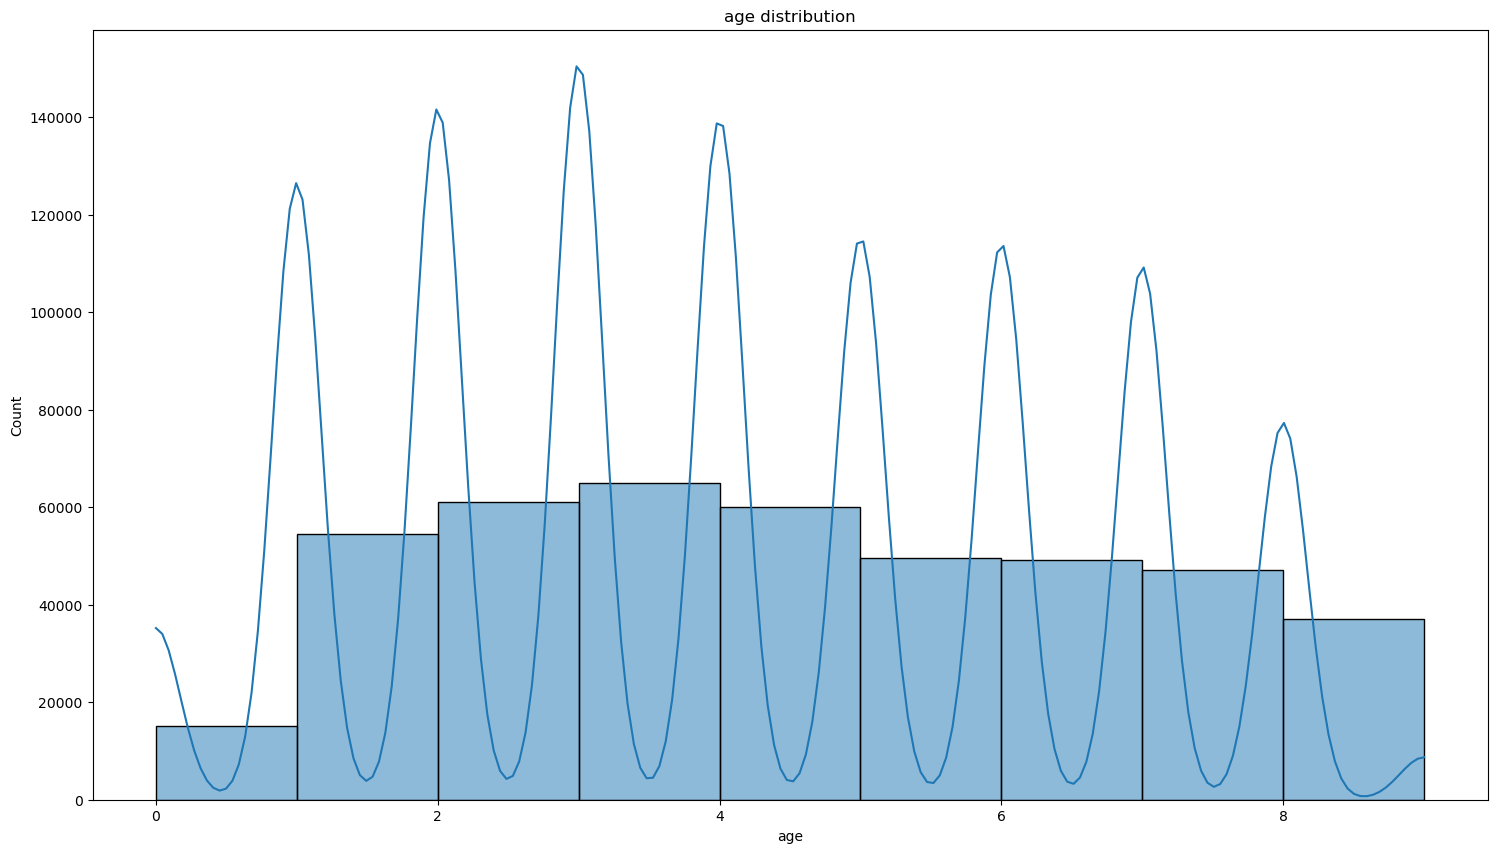

In [106]:
# histogram

fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(application_record["age"], bins = 9, kde=True)
# suppress scientific notation
plt.title('{} distribution'.format("age"))
plt.show()


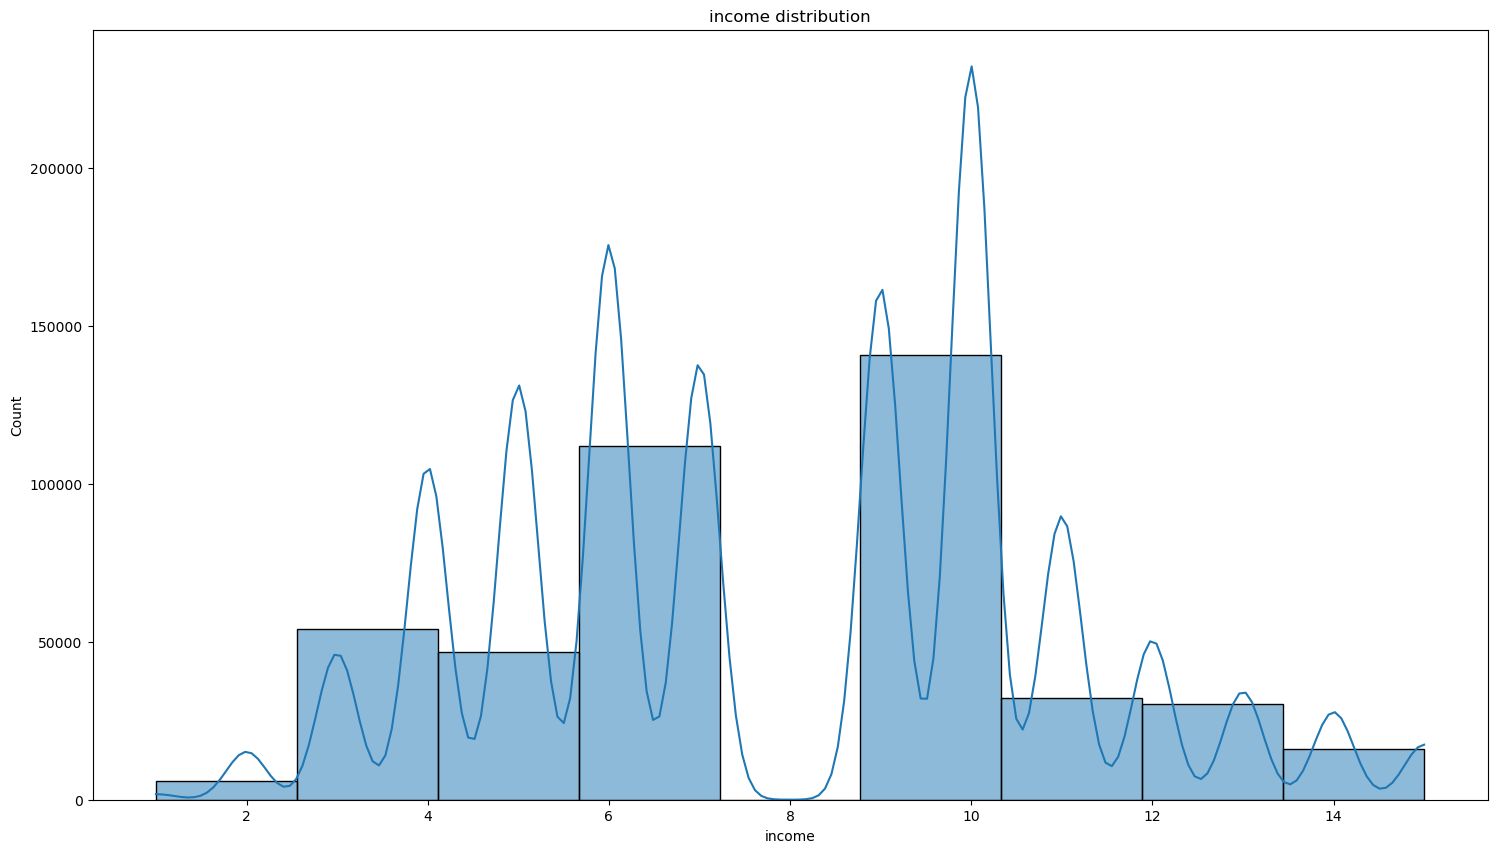

In [107]:
# histogram

fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(application_record["income"], bins = 9, kde=True)
# suppress scientific notation
plt.title('{} distribution'.format("income"))
plt.show()

In [109]:
application_record = application_record.drop(['family_member_count','has_a_mobile'], axis=1)

In [ ]:
# define pipeline steps
#steps = [('outlier_remover', binary_categorical_mapping()),
#        ('drop_children_count', drop_features())]

In [ ]:
# create pipeline
#pipeline = Pipeline(steps)

In [ ]:
# fit pipeline on training data
#pipeline.fit(X_train, y_train)

In [ ]:
# predict on test data
#y_pred = pipeline.predict(X_test)

# evaluate pipeline
#accuracy = pipeline.score(X_test, y_test)

In [ ]:
def data_transformer_pipeline(df):
    
    pipeline = Pipeline([
        ('outlier_remover', binary_categorical_mapping()),
        ('drop_children_count', drop_features())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [ ]:
pd.options.mode.chained_assignment = None  # Hide the copy warning
application_record_transformed = data_transformer_pipeline(application_record)

In [110]:
application_record_transformed.head()

NameError: name 'application_record_transformed' is not defined

In [ ]:
application_record = application_record.drop('no_of_children', axis=1)

In [111]:
application_record.head()

,has_a_car,has_a_property,no_of_children,income,education_level,age,employment_length,has_a_workphone,has_a_phone,has_an_email,...,job_title_Managers,job_title_Medicine staff,job_title_Pensioner,job_title_Private service staff,job_title_Realty agents,job_title_Sales staff,job_title_Secretaries,job_title_Security staff,job_title_Unknown,job_title_Waiters/barmen staff
0,1,1,0,14,3,2,2,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,1,0,14,3,2,2,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,1,0,5,1,7,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,11,1,6,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
4,0,1,0,11,1,6,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0


Converting "Y" and "N" in has_a_car and has_a_property to 1 and 0.

In [113]:
y = application_record["is_risky_customer"]
X = application_record.drop("is_risky_customer", axis = 1)

In [114]:
smote = SMOTE(sampling_strategy = 'minority')
X_sm, y_sm = smote.fit_resample(X,y)

In [115]:
y_sm.value_counts()

0    402716
1    402716
Name: is_risky_customer, dtype: int64

In [116]:
application_record_bal = pd.concat([X_sm, y_sm], axis = 1)

In [117]:
application_record_bal.shape

(805432, 49)

In [118]:
frequency(application_record_bal, "is_risky_customer")

,Count,Frequency (%)
0,402716,50.0
1,402716,50.0


In [119]:
application_record_bal.to_csv("data//application_record_bal.csv", sep=',', encoding='utf-8')